Latex Macros:
$$
\newcommand{\E}{\text{E}}
\newcommand{\mbf}{\mathbf}
\newcommand{\bs}{\boldsymbol}
\newcommand{\Cov}{\text{Cov}}
\newcommand{\Var}{\text{Var}}
\newcommand{\Cov}{\text{Cov}}
\newcommand{\A}[1]{\mathbf{A}_{#1}}
\newcommand{\Ai}[1]{\mathbf{A}^{#1}}
$$

# Inference on difference beteween the most favorable and least favorable genotypic values  

Consider the model:
$$
\mbf{y} = \mbf{1}\bs{\mu} + \mbf{M}\bs{\alpha} + \mbf{e},
$$

where $\mbf{M}$ is a matrix of SNP covariates coded as 0, 1 or 2 (number of copies of the "A" allele). At locus $j$, if the "A" allele is favorable, $\alpha_j$ is positive, and if it is unfavorable,$\alpha_j$ is negative. So, if locus $j$ is favorable, the difference between the favorable and unfavorable homozygotes will be $2 \times \alpha_j$. On the other hand, if locus $j$ is unfavorable, this difference becomes $2\times -\alpha_j$. Thus, at an arbitrary locus, the difference between the favorable and unfavorable homozygotes is $2 \times |\alpha_j|$, and across all the loci, the difference between the most favorable and least favorable genotypic values is:

$$
D = 2\sum_j |\alpha_j|.
$$

But, as the $\bs{\alpha}$ is not observed, $D$ can be estimated as
$$
\hat{D} = 2\sum_j |\hat{\alpha}_j|.
$$

Below are results from several estimators of $\bs{\alpha}$. 

In [1]:
using Statistics, Distributions, JWAS, LinearAlgebra, Printf, Plots, CSV, DataFrames
using Random, DelimitedFiles

In [2]:
Identity(n) = Matrix(I,n,n)

Identity (generic function with 1 method)

In [5]:
function getEstimates(n,p,probNull, Vg, Ve)
    X = rand(Binomial(2,0.5), n,p)
    CSV.write("genotypes",DataFrame([string.(1:n) X]), writeheader=false)
    pNull = Int(probNull*p)
    pNonNull = p - pNull
    Valpha = 2Vg/pNonNull
    α = [randn(pNonNull)*sqrt(Valpha); zeros(pNull)]
    y = X*α + randn(n) .* sqrt(Ve)
    data = DataFrame([string.(1:n) y])
    names!(data,[:ind, :y])
    
    function BayesX(Vg, Ve,options)
        model = build_model("y = intercept", Ve)
        add_genotypes(model,"genotypes", Vg; G_is_marker_variance=false, separator=',',header=false)
        output = runMCMC(model,data;
                Pi                  = options.pi,
                burnin              = 1000,
                chain_length        = 11000,
                starting_value      = false,
                missing_phenotypes  = false,
                constraint          = false,
                estimatePi          = options.estimatePi,
                estimateScale       = options.estimateScale,
                estimate_variance   = options.estimateVariance,
                methods             = options.method,
                printout_frequency  = 5_000,
                printout_model_info = false,
                output_samples_frequency = 10,
                update_priors_frequency=0,
                #parameters for single-step analysis
                single_step_analysis= false,
                pedigree            = false,
                #output
                #Genomic Prediction
                outputEBV               = false,
                output_heritability     = false
        )
        sampleMat = DelimitedFiles.readdlm("MCMC_samples_marker_effects_y.txt",',')
        
        αHat  = output["Posterior mean of marker effects"]
        res1  = 2*sum(abs.(αHat))           # f(posterior mean), where f=abs()
        res2  = mean(2*sum(abs.(sampleMat),dims=2)) # posterior mean of f
        return (analysis=options.analysis,result1=res1,result2=res2)
    end
    optionVec = []
    push!(optionVec,(analysis="BayesA Scale known  ",  pi=0.0, estimatePi=false,estimateScale=false, estimateVariance=false,method="BayesB"))
    push!(optionVec,(analysis="BayesA Scale unknown",pi=0.0, estimatePi=false,estimateScale=true,  estimateVariance=false,method="BayesB"))
    push!(optionVec,(analysis="BayesB Scale known  ",pi=0.5, estimatePi=true, estimateScale=false, estimateVariance=false,method="BayesB"))
    push!(optionVec,(analysis="BayesB Scale unknown",pi=0.5, estimatePi=true, estimateScale=true,  estimateVariance=false,method="BayesB"))    
    push!(optionVec,(analysis="BayesCPi            ",pi=0.5, estimatePi=true, estimateScale=false, estimateVariance=true,method="BayesC"))
    push!(optionVec,(analysis="BayesC0             ",pi=0.0, estimatePi=false,estimateScale=false, estimateVariance=true,method="BayesC"))
    push!(optionVec,(analysis="RRBLUP              ",pi=0.0, estimatePi=false,estimateScale=false, estimateVariance=false,method="RR-BLUP"))
    (estimates=[BayesX(Vg, Ve,i) for i in optionVec],trueVal = 2*sum(abs.(α)) )
end

getEstimates (generic function with 1 method)

### Comparison of BayesA, BayesB, BayesCPi, RR-BLUP and OLS with Sample size n = 100 and number p = 20 of markers and $\pi = 0.75$

In [14]:
probNull = 0.75
n  = 100
p  = 20
N  = 25
Vg = 10
Ve = 10
Random.seed!(1234)
resSim = [getEstimates(n,p,probNull,Vg, Ve) for i=1:N];

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 20%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 9.154258


running MCMC for BayesB... 61%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.189401


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.421096


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.367453


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.218591
π: 0.627


running MCMC for BayesB... 31%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.206238
π: 0.623


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.298272
π: 0.546


running MCMC for BayesB... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.318895
π: 0.544


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.236618
Marker effects variance: 1.344904
π: 0.581

Posterior means at iteration: 10000
Residual variance: 9.264932
Marker effects variance: 1.370621
π: 0.588


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.484948
Marker effects variance: 0.4618

Posterior means at iteration: 10000
Residual variance: 9.487161
Marker effects variance: 0.455522


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.236229
Marker effects variance: 1.004127

Posterior means at iteration: 10000
Residual variance: 9.227566
Marker effects variance: 1.004127


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004329


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.876161


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.902839


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004329


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.839136


running MCMC for BayesB... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.836905


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008657


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.792812
π: 0.391


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.78784
π: 0.387


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008657


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.803792
π: 0.4


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.81376
π: 0.401


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008657


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.844094
Marker effects variance: 1.794415
π: 0.418

Posterior means at iteration: 10000
Residual variance: 11.838393
Marker effects variance: 1.794722
π: 0.421


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004329


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.045387
Marker effects variance: 0.887232

Posterior means at iteration: 10000
Residual variance: 12.082607
Marker effects variance: 0.891001


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004329


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.874481
Marker effects variance: 1.004329

Posterior means at iteration: 10000
Residual variance: 11.838008
Marker effects variance: 1.004329


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003311


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.938564

Posterior means at iteration: 10000
Residual variance: 7.919623


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003311


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.939887


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.960582


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006622


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.972539
π: 0.693

Posterior means at iteration: 10000
Residual variance: 7.973502
π: 0.695


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006622


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.967904
π: 0.7


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.975349
π: 0.689


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006622


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.00693
Marker effects variance: 2.417304
π: 0.735

Posterior means at iteration: 10000
Residual variance: 7.995613
Marker effects variance: 2.384234
π: 0.731


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003311


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.160876
Marker effects variance: 0.574141

Posterior means at iteration: 10000
Residual variance: 8.188484
Marker effects variance: 0.575127


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003311


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.043804
Marker effects variance: 1.003311

Posterior means at iteration: 10000
Residual variance: 8.063276
Marker effects variance: 1.003311


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00321


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.416626


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 

running MCMC for BayesB... 62%|████████████████         |  ETA: 0:00:00

10.380301


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00321


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 21%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.387423


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.378111


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006421


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.563063
π: 0.357


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.555307
π: 0.361


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006421


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.623324
π: 0.372


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.637362
π: 0.36


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006421


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.699375
Marker effects variance: 1.812489
π: 0.415

Posterior means at iteration: 10000
Residual variance: 10.687184
Marker effects variance: 1.791715
π: 0.406


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00321


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.573322
Marker effects variance: 0.972601


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.566916
Marker effects variance: 0.979992


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00321


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.426588
Marker effects variance: 1.00321

Posterior means at iteration: 10000
Residual variance: 10.429119
Marker effects variance: 1.00321


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.010331


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.875316


running MCMC for BayesB... 55%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.862342


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.010331


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 16%|████                     |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.921382


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.968224


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.020661


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.091786
π: 0.593


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.030969
π: 0.584


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.020661


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.094294
π: 0.509


running MCMC for BayesB... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.096863
π: 0.518


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.020661


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.064813
Marker effects variance: 1.353721
π: 0.571

Posterior means at iteration: 10000
Residual variance: 10.079684
Marker effects variance: 1.37719
π: 0.58


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.010331


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.088073
Marker effects variance: 0.519428


running MCMC for BayesC... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.134516
Marker effects variance: 0.517765


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.010331


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.907344
Marker effects variance: 1.010331

Posterior means at iteration: 10000
Residual variance: 9.902002
Marker effects variance: 1.010331


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.787588

Posterior means at iteration: 10000
Residual variance: 7.774852


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.750207


running MCMC for BayesB... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.766841


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.857027
π: 0.439


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.849917
π: 0.444


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.869613
π: 0.439


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.847996
π: 0.44


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.894984
Marker effects variance: 1.883261
π: 0.487

Posterior means at iteration: 10000
Residual variance: 7.864025
Marker effects variance: 1.895644
π: 0.487


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.865408
Marker effects variance: 0.887733

Posterior means at iteration: 10000
Residual variance: 7.870688
Marker effects variance: 0.881638


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.816001
Marker effects variance: 1.007374

Posterior means at iteration: 10000
Residual variance: 7.804483
Marker effects variance: 1.007374


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002949


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.709883


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.709724


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002949


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.651108


running MCMC for BayesB... 50%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.687136


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005897


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.356612
π: 0.627


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.351364
π: 0.625


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005897


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.348062
π: 0.646


running MCMC for BayesB... 28%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.367379
π: 0.652


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005897


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.332153
Marker effects variance: 3.069289
π: 0.687


running MCMC for BayesC... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.35201
Marker effects variance: 3.016094
π: 0.682


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002949


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.03543
Marker effects variance: 0.825643

Posterior means at iteration: 10000
Residual variance: 9.018431
Marker effects variance: 0.836348


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002949


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.902175
Marker effects variance: 1.002949

Posterior means at iteration: 10000
Residual variance: 8.882121
Marker effects variance: 1.002949


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007044


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.025158

Posterior means at iteration: 10000
Residual variance: 13.014706


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007044


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.220216

Posterior means at iteration: 10000
Residual variance: 13.290283


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014089


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.19965
π: 0.729

Posterior means at iteration: 10000
Residual variance: 13.190155
π: 0.73


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014089


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.264162
π: 0.571


running MCMC for BayesB... 31%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 13.29105
π: 0.602


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014089


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.151677
Marker effects variance: 1.213991
π: 0.663

Posterior means at iteration: 10000
Residual variance: 13.142623
Marker effects variance: 1.222561
π: 0.66


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007044


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.139622
Marker effects variance: 0.342948

Posterior means at iteration: 10000
Residual variance: 13.120766
Marker effects variance: 0.339683


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007044


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.054726
Marker effects variance: 1.007044

Posterior means at iteration: 10000
Residual variance: 13.072256
Marker effects variance: 1.007044


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.13939


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.132557


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.127832

Posterior means at iteration: 10000
Residual variance: 8.129101


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012072


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.998487
π: 0.655


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.995964
π: 0.657


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012072


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.015408
π: 0.647


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.029328
π: 0.67


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012072


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.027359
Marker effects variance: 3.195152
π: 0.727

Posterior means at iteration: 10000
Residual variance: 8.020845
Marker effects variance: 3.210491
π: 0.726


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.472622
Marker effects variance: 0.896824

Posterior means at iteration: 10000
Residual variance: 8.521861
Marker effects variance: 0.881412


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.352741
Marker effects variance: 1.006036

Posterior means at iteration: 10000
Residual variance: 8.366725
Marker effects variance: 1.006036


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004112


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 16%|████                     |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.682525


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.7002


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004112


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 17%|████                     |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.842044


running MCMC for BayesB... 57%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.86939


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008224


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.591354
π: 0.617


running MCMC for BayesB... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.607117
π: 0.617


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008224


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 19%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.657871
π: 0.552


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.664993
π: 0.556


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008224


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.642963
Marker effects variance: 1.298247
π: 0.561


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.625478
Marker effects variance: 1.313447
π: 0.568


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004112


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.938067
Marker effects variance: 0.467897

Posterior means at iteration: 10000
Residual variance: 10.929111
Marker effects variance: 0.467762


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004112


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.655583
Marker effects variance: 1.004112


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.655622
Marker effects variance: 1.004112


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00443


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.892681


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.905431


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00443


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.070917


running MCMC for BayesB... 49%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.080463


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008859


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.24839
π: 0.443


running MCMC for BayesB... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.260636
π: 0.453


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008859


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.255427
π: 0.353


running MCMC for BayesB... 61%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.283985
π: 0.357


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008859


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.237684
Marker effects variance: 1.094691
π: 0.399


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.262344
Marker effects variance: 1.073312
π: 0.4


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00443


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.112822
Marker effects variance: 0.537629


running MCMC for BayesC... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.093941
Marker effects variance: 0.537899


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00443


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.884767
Marker effects variance: 1.00443

Posterior means at iteration: 10000
Residual variance: 11.860051
Marker effects variance: 1.00443


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004601


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.212248


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.241757


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004601


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.371249


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.379157


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.397028
π: 0.616


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.397011
π: 0.601


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.445304
π: 0.582


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.438739
π: 0.58


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.473927
Marker effects variance: 2.399881
π: 0.658

Posterior means at iteration: 10000
Residual variance: 9.465558
Marker effects variance: 2.304477
π: 0.647


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004601


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.536049
Marker effects variance: 0.796076

Posterior means at iteration: 10000
Residual variance: 9.568403
Marker effects variance: 0.785285


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004601


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.324611
Marker effects variance: 1.004601

Posterior means at iteration: 10000
Residual variance: 9.34272
Marker effects variance: 1.004601


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.394153


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.377489


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.394862


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.37924


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013724


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.404548
π: 0.439


running MCMC for BayesB... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.427699
π: 0.439


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013724


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.470423
π: 0.438


running MCMC for BayesB... 57%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.486086
π: 0.439


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013724


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.567655
Marker effects variance: 2.171948
π: 0.498


running MCMC for BayesC... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.557126
Marker effects variance: 2.178788
π: 0.496


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.62919
Marker effects variance: 1.002446


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.641253
Marker effects variance: 0.997053


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.538296
Marker effects variance: 1.006862


running MCMC for RR-BLUP... 45%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.532022
Marker effects variance: 1.006862


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004727


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.978617


running MCMC for BayesB... 61%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.930657


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004727


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.097197


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.053594


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009454


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.152186
π: 0.754


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.147302
π: 0.759


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009454


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.220419
π: 0.616


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.172882
π: 0.601


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009454


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.075916
Marker effects variance: 1.069857
π: 0.683

Posterior means at iteration: 10000
Residual variance: 9.100794
Marker effects variance: 1.080054
π: 0.695


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004727


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.942576
Marker effects variance: 0.292886

Posterior means at iteration: 10000
Residual variance: 8.946005
Marker effects variance: 0.291835


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004727


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.008614
Marker effects variance: 1.004727

Posterior means at iteration: 10000
Residual variance: 8.986712
Marker effects variance: 1.004727


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.094558

Posterior means at iteration: 10000
Residual variance: 11.071713


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.110223

Posterior means at iteration: 10000
Residual variance: 11.057748


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01266


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.731532
π: 0.504

Posterior means at iteration: 10000
Residual variance: 11.703558
π: 0.493


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01266


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.689236
π: 0.46


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.624693
π: 0.436


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01266


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.725988
Marker effects variance: 1.742431
π: 0.497

Posterior means at iteration: 10000
Residual variance: 11.791653
Marker effects variance: 1.797197
π: 0.513


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.301876
Marker effects variance: 0.769178

Posterior means at iteration: 10000
Residual variance: 11.319386
Marker effects variance: 0.766135


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.134411
Marker effects variance: 1.00633

Posterior means at iteration: 10000
Residual variance: 11.14014
Marker effects variance: 1.00633


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005025


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.772345

Posterior means at iteration: 10000
Residual variance: 10.788402


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005025


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.876601


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.880703


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01005


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.885338
π: 0.776

Posterior means at iteration: 10000
Residual variance: 10.864402
π: 0.781


running MCMC for BayesB... 50%|████████████             |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01005


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.87609
π: 0.637


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.898388
π: 0.653


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01005


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.859445
Marker effects variance: 1.119104
π: 0.721

Posterior means at iteration: 10000
Residual variance: 10.865514
Marker effects variance: 1.150188
π: 0.718


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005025


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.766618
Marker effects variance: 0.278045

Posterior means at iteration: 10000
Residual variance: 10.773135
Marker effects variance: 0.27872


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005025


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.943748
Marker effects variance: 1.005025

Posterior means at iteration: 10000
Residual variance: 10.907518
Marker effects variance: 1.005025


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003371


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.418387


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.395568


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003371


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.394982


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.389462


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006743


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.556004
π: 0.428

Posterior means at iteration: 10000
Residual variance: 11.571766
π: 0.415


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006743


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.618735
π: 0.428


running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.624184
π: 0.421


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006743


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.722331
Marker effects variance: 2.427298
π: 0.492

Posterior means at iteration: 10000
Residual variance: 11.725446
Marker effects variance: 2.42427
π: 0.493


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003371


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.67928
Marker effects variance: 1.09151

Posterior means at iteration: 10000
Residual variance: 11.721196
Marker effects variance: 1.092411


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003371


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.545926
Marker effects variance: 1.003371

Posterior means at iteration: 10000
Residual variance: 11.557375
Marker effects variance: 1.003371


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002903


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.005527

Posterior means at iteration: 10000
Residual variance: 7.008127


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002903


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.028211


running MCMC for BayesB... 46%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.02811


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005807


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 6.878021
π: 0.562

Posterior means at iteration: 10000
Residual variance: 6.875688
π: 0.562


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005807


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 6.863356
π: 0.622


running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.863843
π: 0.626


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005807


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 6.93879
Marker effects variance: 5.081223
π: 0.675

Posterior means at iteration: 10000
Residual variance: 6.914757
Marker effects variance: 5.036544
π: 0.673


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002903


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.219099
Marker effects variance: 1.69172

Posterior means at iteration: 10000
Residual variance: 7.226207
Marker effects variance: 1.67986


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002903


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.361691
Marker effects variance: 1.002903

Posterior means at iteration: 10000
Residual variance: 7.368463
Marker effects variance: 1.002903


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007181


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.281483


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.255775


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007181


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.20133

Posterior means at iteration: 10000
Residual variance: 8.240186


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014362


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.239817
π: 0.49

Posterior means at iteration: 10000
Residual variance: 8.256989
π: 0.491


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014362


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.243697
π: 0.522


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.272898
π: 0.525


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014362


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.31815
Marker effects variance: 3.43723
π: 0.587

Posterior means at iteration: 10000
Residual variance: 8.331231
Marker effects variance: 3.444293
π: 0.59


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007181


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.508769
Marker effects variance: 1.333984

Posterior means at iteration: 10000
Residual variance: 8.502487
Marker effects variance: 1.321681


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007181


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.569639
Marker effects variance: 1.007181


running MCMC for RR-BLUP... 46%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.564055
Marker effects variance: 1.007181


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004556


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.559519


running MCMC for BayesB... 31%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.579247


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004556


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.710042


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.696141


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009111


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.717909
π: 0.663


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.727208
π: 0.664


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009111


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.730875
π: 0.597


running MCMC for BayesB... 49%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.734963
π: 0.608


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009111


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.751772
Marker effects variance: 1.41686
π: 0.641

Posterior means at iteration: 10000
Residual variance: 7.75402
Marker effects variance: 1.435914
π: 0.644


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004556


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.788198
Marker effects variance: 0.443242

Posterior means at iteration: 10000
Residual variance: 7.785521
Marker effects variance: 0.439085


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004556


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.621823
Marker effects variance: 1.004556

Posterior means at iteration: 10000
Residual variance: 7.637366
Marker effects variance: 1.004556


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004384


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.95125

Posterior means at iteration: 10000
Residual variance: 9.963816


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004384


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.017808


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.048524


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008768


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.051946
π: 0.661

Posterior means at iteration: 10000
Residual variance: 10.033311
π: 0.658


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008768


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.031389
π: 0.603

Posterior means at iteration: 10000
Residual variance: 10.036584
π: 0.609


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008768


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.011369
Marker effects variance: 1.831096
π: 0.666

Posterior means at iteration: 10000
Residual variance: 9.989975
Marker effects variance: 1.748324
π: 0.647


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004384


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.256712
Marker effects variance: 0.514659

Posterior means at iteration: 10000
Residual variance: 10.254826
Marker effects variance: 0.507418


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004384


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.022302
Marker effects variance: 1.004384

Posterior means at iteration: 10000
Residual variance: 10.013881
Marker effects variance: 1.004384


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.395413

Posterior means at iteration: 10000
Residual variance: 10.408942


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.605626

Posterior means at iteration: 10000
Residual variance: 10.601793


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013724


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.542364
π: 0.579

Posterior means at iteration: 10000
Residual variance: 10.565319
π: 0.576


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013724


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.638143
π: 0.506


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.666284
π: 0.509


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013724


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.613511
Marker effects variance: 1.545058
π: 0.561

Posterior means at iteration: 10000
Residual variance: 10.628835
Marker effects variance: 1.553658
π: 0.565


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.822152
Marker effects variance: 0.563261

Posterior means at iteration: 10000
Residual variance: 10.848212
Marker effects variance: 0.560691


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006862


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.491393
Marker effects variance: 1.006862

Posterior means at iteration: 10000
Residual variance: 10.497329
Marker effects variance: 1.006862


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.978125

Posterior means at iteration: 10000
Residual variance: 11.008533


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.035948

Posterior means at iteration: 10000
Residual variance: 11.058166


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011678


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.693418
π: 0.621

Posterior means at iteration: 10000
Residual variance: 10.715592
π: 0.621


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011678


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.762635
π: 0.641

Posterior means at iteration: 10000
Residual variance: 10.731135
π: 0.644


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011678


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.679832
Marker effects variance: 3.077556
π: 0.683

Posterior means at iteration: 10000
Residual variance: 10.690807
Marker effects variance: 3.097292
π: 0.683


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.575968
Marker effects variance: 0.8168

Posterior means at iteration: 10000
Residual variance: 11.567498
Marker effects variance: 0.828695


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.33607
Marker effects variance: 1.005839

Posterior means at iteration: 10000
Residual variance: 11.312759
Marker effects variance: 1.005839


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005465


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.320179

Posterior means at iteration: 10000
Residual variance: 10.323151


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005465


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.455613

Posterior means at iteration: 10000
Residual variance: 10.430354


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010929


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.111541
π: 0.455

Posterior means at iteration: 10000
Residual variance: 10.081345
π: 0.459


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010929


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.118081
π: 0.434


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.118625
π: 0.438


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010929


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.090805
Marker effects variance: 1.597376
π: 0.459

Posterior means at iteration: 10000
Residual variance: 10.101044
Marker effects variance: 1.588998
π: 0.46


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005465


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.553171
Marker effects variance: 0.700874

Posterior means at iteration: 10000
Residual variance: 10.556804
Marker effects variance: 0.692526


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005465


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.248857
Marker effects variance: 1.005465

Posterior means at iteration: 10000
Residual variance: 10.270736
Marker effects variance: 1.005465


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.720157

Posterior means at iteration: 10000
Residual variance: 9.699593


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.863818

Posterior means at iteration: 10000
Residual variance: 9.845568


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005636


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.696527
π: 0.571

Posterior means at iteration: 10000
Residual variance: 9.741623
π: 0.564


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005636


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.819391
π: 0.526


running MCMC for BayesB... 49%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.809629
π: 0.537


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005636


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.781828
Marker effects variance: 1.902959
π: 0.601

Posterior means at iteration: 10000
Residual variance: 9.778389
Marker effects variance: 1.898065
π: 0.602


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.150743
Marker effects variance: 0.642826

Posterior means at iteration: 10000
Residual variance: 10.148848
Marker effects variance: 0.642272


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.780191
Marker effects variance: 1.002818

Posterior means at iteration: 10000
Residual variance: 9.810701
Marker effects variance: 1.002818


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


In [15]:
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result1 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end
println("------------------------------------------")
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result2 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end

     True value           13.90  +/- 0.157 
     BayesA Scale known   19.67  +/- 0.175 
     BayesA Scale unknown 18.07  +/- 0.237 
     BayesB Scale known   15.21  +/- 0.227 
     BayesB Scale unknown 14.96  +/- 0.222 
     BayesCPi             14.91  +/- 0.214 
     BayesC0              18.70  +/- 0.217 
     RRBLUP               20.94  +/- 0.161 
------------------------------------------
     True value           13.90  +/- 0.157 
     BayesA Scale known   24.60  +/- 0.152 
     BayesA Scale unknown 22.68  +/- 0.232 
     BayesB Scale known   16.62  +/- 0.238 
     BayesB Scale unknown 16.50  +/- 0.224 
     BayesCPi             16.20  +/- 0.215 
     BayesC0              23.75  +/- 0.205 
     RRBLUP               26.17  +/- 0.136 


In [68]:
a = [13.90 
     19.67 
     18.07
     15.21
     14.96 
     14.91
     18.70
     20.94]
b100 = (a[2:end] .- a[1])./a[1]*100

7-element Array{Float64,1}:
 41.51079136690649  
 30.0               
  9.42446043165468  
  7.625899280575544 
  7.2661870503597115
 34.532374100719416 
 50.64748201438849  

In [16]:
biasMat = [row.estimates[i].result1 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  5.76715  0.108532
 "BayesA Scale unknown"  4.16257  0.143936
 "BayesB Scale known  "  1.30507  0.132815
 "BayesB Scale unknown"  1.05941  0.128231
 "BayesCPi            "  1.00332  0.1237  
 "BayesC0             "  4.79244  0.135523
 "RRBLUP              "  7.03251  0.119491

In [17]:
biasMat = [row.estimates[i].result2 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  10.6923   0.0902367
 "BayesA Scale unknown"   8.77789  0.134526 
 "BayesB Scale known  "   2.71635  0.144278 
 "BayesB Scale unknown"   2.59638  0.134845 
 "BayesCPi            "   2.29203  0.130863 
 "BayesC0             "   9.84604  0.118135 
 "RRBLUP              "  12.2625   0.0973799

### Comparison of BayesA, BayesB, BayesCPi, RR-BLUP and OLS with Sample size n = 200 and number p = 20 of markers and $\pi = 0.75$

In [51]:
probNull = 0.75
n  = 200
p  = 20
N  = 25
Vg = 10
Ve = 10
Random.seed!(1234)
resSim = [getEstimates(n,p,probNull,Vg, Ve) for i=1:N];

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002231


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB...  5%|█                        |  ETA: 0:00:07


Posterior means at iteration: 5000
Residual variance: 9.085365


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.103467


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002231


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.157036


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.131091


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004462


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.15045
π: 0.543


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.146576
π: 0.536


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004462


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.17445
π: 0.593


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.18121
π: 0.592


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004462


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.210518
Marker effects variance: 3.555963
π: 0.635

Posterior means at iteration: 10000
Residual variance: 9.216678
Marker effects variance: 3.618691
π: 0.629


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002231


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.184334
Marker effects variance: 1.363209

Posterior means at iteration: 10000
Residual variance: 9.168524
Marker effects variance: 1.368801


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002231


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.208976
Marker effects variance: 1.002231

Posterior means at iteration: 10000
Residual variance: 9.209782
Marker effects variance: 1.002231


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002632


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.105236


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.120666


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002632


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.123735


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.129838


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.119632
π: 0.598


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.123677
π: 0.599


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.096356
π: 0.489


running MCMC for BayesB... 61%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.121875
π: 0.505


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.113602
Marker effects variance: 1.063659
π: 0.548

Posterior means at iteration: 10000
Residual variance: 10.103247
Marker effects variance: 1.061814
π: 0.549


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002632


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.153609
Marker effects variance: 0.398587

Posterior means at iteration: 10000
Residual variance: 10.175974
Marker effects variance: 0.397597


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002632


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.134553
Marker effects variance: 1.002632

Posterior means at iteration: 10000
Residual variance: 10.126617
Marker effects variance: 1.002632


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.34877


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.327908


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.315148


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.331177


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004528


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.267933
π: 0.764


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.268373
π: 0.765


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004528


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.269544
π: 0.712


running MCMC for BayesB... 62%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.275799
π: 0.704


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004528


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.264048
Marker effects variance: 1.424792
π: 0.747

Posterior means at iteration: 10000
Residual variance: 11.260306
Marker effects variance: 1.424209
π: 0.745


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.396381
Marker effects variance: 0.306742

Posterior means at iteration: 10000
Residual variance: 11.422114
Marker effects variance: 0.309574


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.399401
Marker effects variance: 1.002264

Posterior means at iteration: 10000
Residual variance: 11.403786
Marker effects variance: 1.002264


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001644


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.413074


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.400827


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001644


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.389675


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.376362


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003288


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.234748
π: 0.65


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.223898
π: 0.645


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003288


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.219182
π: 0.675


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.212837
π: 0.677


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003288


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.214238
Marker effects variance: 4.192592
π: 0.706

Posterior means at iteration: 10000
Residual variance: 9.226409
Marker effects variance: 4.20527
π: 0.707


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001644


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.513407
Marker effects variance: 1.242524


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.507241
Marker effects variance: 1.242637


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001644


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.526043
Marker effects variance: 1.001644

Posterior means at iteration: 10000
Residual variance: 9.51889
Marker effects variance: 1.001644


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002539


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.944086


running MCMC for BayesB... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.947091


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002539


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.992687


running MCMC for BayesB... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.000132


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005078


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.017037
π: 0.578


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.021609
π: 0.576


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005078


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.017953
π: 0.49


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.042102
π: 0.502


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005078


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.038039
Marker effects variance: 1.174899
π: 0.543


running MCMC for BayesC... 49%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.01992
Marker effects variance: 1.17479
π: 0.544


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002539


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.028545
Marker effects variance: 0.467574


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.018409
Marker effects variance: 0.470848


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002539


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.964716
Marker effects variance: 1.002539

Posterior means at iteration: 10000
Residual variance: 8.963401
Marker effects variance: 1.002539


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002114


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.06487


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.041943


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002114


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.994661


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.995265


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004229


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.761852
π: 0.719


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.765288
π: 0.718


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004229


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.793962
π: 0.738


running MCMC for BayesB... 64%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.765661
π: 0.737


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004229


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.776906
Marker effects variance: 3.474508
π: 0.758


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.765112
Marker effects variance: 3.50525
π: 0.757


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002114


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.130751
Marker effects variance: 0.852267

Posterior means at iteration: 10000
Residual variance: 10.148381
Marker effects variance: 0.854013


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002114


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.116233
Marker effects variance: 1.002114

Posterior means at iteration: 10000
Residual variance: 10.129978
Marker effects variance: 1.002114


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002273


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.30255


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.308931


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002273


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.27343


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.293845


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004545


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.156067
π: 0.535


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.145846
π: 0.535


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004545


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.097335
π: 0.574


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.124569
π: 0.577


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004545


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.117748
Marker effects variance: 2.781333
π: 0.589

Posterior means at iteration: 10000
Residual variance: 9.133701
Marker effects variance: 2.82568
π: 0.595


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002273


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.355297
Marker effects variance: 1.120871

Posterior means at iteration: 10000
Residual variance: 9.358044
Marker effects variance: 1.129991


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002273


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.364111
Marker effects variance: 1.002273

Posterior means at iteration: 10000
Residual variance: 9.350739
Marker effects variance: 1.002273


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002356


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.574014


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.566562


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002356


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.524735


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.537122


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004711


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.604205
π: 0.653


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.616726
π: 0.659


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004711


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.610041
π: 0.709


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.62341
π: 0.713


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004711


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.635307
Marker effects variance: 9.08223
π: 0.764

Posterior means at iteration: 10000
Residual variance: 8.641986
Marker effects variance: 9.193187
π: 0.764


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002356


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.635721
Marker effects variance: 2.395577

Posterior means at iteration: 10000
Residual variance: 8.630923
Marker effects variance: 2.415703


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002356


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.762075
Marker effects variance: 1.002356

Posterior means at iteration: 10000
Residual variance: 8.760721
Marker effects variance: 1.002356


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.996574


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.980944


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.976787


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.959217


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.916461
π: 0.577


running MCMC for BayesB... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.917087
π: 0.576


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.915408
π: 0.586


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.931556
π: 0.592


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.974562
Marker effects variance: 3.45159
π: 0.648

Posterior means at iteration: 10000
Residual variance: 9.981465
Marker effects variance: 3.465413
π: 0.652


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.079598
Marker effects variance: 1.176304

Posterior means at iteration: 10000
Residual variance: 10.049975
Marker effects variance: 1.177011


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.075734
Marker effects variance: 1.001317

Posterior means at iteration: 10000
Residual variance: 10.066333
Marker effects variance: 1.001317


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001029


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.896236


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.908401


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001029


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.919422


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.908835


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002057


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.007218
π: 0.573


running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.034159
π: 0.567


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002057


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.079481
π: 0.588


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.079852
π: 0.589


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002057


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.104607
Marker effects variance: 2.831724
π: 0.647

Posterior means at iteration: 10000
Residual variance: 9.095462
Marker effects variance: 2.797681
π: 0.646


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001029


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.005665
Marker effects variance: 0.923113

Posterior means at iteration: 10000
Residual variance: 8.991965
Marker effects variance: 0.926056


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001029


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.955393
Marker effects variance: 1.001029

Posterior means at iteration: 10000
Residual variance: 8.96121
Marker effects variance: 1.001029


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.675638

Posterior means at iteration: 10000
Residual variance: 9.66415


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.719773


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.74545


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004131


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.895824
π: 0.674


running MCMC for BayesB... 50%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.893791
π: 0.671


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004131


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.810071
π: 0.54


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.802373
π: 0.524


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004131


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.834219
Marker effects variance: 0.964964
π: 0.603

Posterior means at iteration: 10000
Residual variance: 9.825878
Marker effects variance: 0.944634
π: 0.594


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.695559
Marker effects variance: 0.310628

Posterior means at iteration: 10000
Residual variance: 9.72446
Marker effects variance: 0.311811


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.690749
Marker effects variance: 1.002066

Posterior means at iteration: 10000
Residual variance: 9.705859
Marker effects variance: 1.002066


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001268


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.907741


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.902644


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001268


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 20%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 8.920899


running MCMC for BayesB... 73%|██████████████████       |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.928825


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002536


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.07525
π: 0.605


running MCMC for BayesB... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.058645
π: 0.599


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002536


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.086183
π: 0.642


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.076483
π: 0.642


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002536


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.152096
Marker effects variance: 4.762347
π: 0.701

Posterior means at iteration: 

running MCMC for BayesC... 37%|█████████                |  ETA: 0:00:00

10000
Residual variance: 9.138451
Marker effects variance: 4.766111
π: 0.703


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001268


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.988994
Marker effects variance: 1.411979


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.014815
Marker effects variance: 1.419012


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001268


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.004563
Marker effects variance: 1.001268


running MCMC for RR-BLUP... 47%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.009147
Marker effects variance: 1.001268


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003378


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.196026


running MCMC for BayesB... 62%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.183597


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003378


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.292942


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.271717


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006755


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.381709
π: 0.705


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.378621
π: 0.706


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006755


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.336426
π: 0.451


running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.35007
π: 0.483


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006755


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.331578
Marker effects variance: 0.870049
π: 0.603

Posterior means at iteration: 10000
Residual variance: 11.32462
Marker effects variance: 0.883956
π: 0.607


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003378


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.153123
Marker effects variance: 0.274488

Posterior means at iteration: 10000
Residual variance: 11.161164
Marker effects variance: 0.275158


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003378


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.175174
Marker effects variance: 1.003378

Posterior means at iteration: 10000
Residual variance: 11.180963
Marker effects variance: 1.003378


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002255


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.136956


running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.1466


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002255


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.154389


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.154882


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00451


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.172183
π: 0.577


running MCMC for BayesB... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.17027
π: 0.578


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00451


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.181851
π: 0.56


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.185417
π: 0.562


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00451


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.217078
Marker effects variance: 2.18783
π: 0.624

Posterior means at iteration: 10000
Residual variance: 9.222329
Marker effects variance: 2.204717
π: 0.624


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002255


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.263482
Marker effects variance: 0.75216


running MCMC for BayesC... 30%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.247115
Marker effects variance: 0.76247


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002255


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.190834
Marker effects variance: 1.002255

Posterior means at iteration: 10000
Residual variance: 9.184314
Marker effects variance: 1.002255


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.577484


running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.602341


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.600453


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.579307


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006529


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.536334
π: 0.673


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.54313
π: 0.668


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006529


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.542668
π: 0.6


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.532906
π: 0.599


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006529


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.502703
Marker effects variance: 1.231258
π: 0.634

Posterior means at iteration: 10000
Residual variance: 10.520426
Marker effects variance: 1.226416
π: 0.637


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.641422
Marker effects variance: 0.372296

Posterior means at iteration: 10000
Residual variance: 10.618879
Marker effects variance: 0.370497


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003264


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.600701
Marker effects variance: 1.003264

Posterior means at iteration: 10000
Residual variance: 10.600419
Marker effects variance: 1.003264


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001896


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.77553


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.776523


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001896


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.798793


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.790987


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003792


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.815839
π: 0.582


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.823927
π: 0.582


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003792


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.845066
π: 0.599


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.850241
π: 0.598


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003792


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.866613
Marker effects variance: 2.210944
π: 0.621


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.861997
Marker effects variance: 2.223754
π: 0.626


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001896


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.866481
Marker effects variance: 0.814333


running MCMC for BayesC... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.86041
Marker effects variance: 0.811248


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001896


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.829362
Marker effects variance: 1.001896

Posterior means at iteration: 10000
Residual variance: 8.824072
Marker effects variance: 1.001896


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.385434


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.368297


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.271056


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.29232


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006634


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.286216
π: 0.76


running MCMC for BayesB... 50%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.280082
π: 0.76


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006634


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.263347
π: 0.756


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.268051
π: 0.749


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006634


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.28641
Marker effects variance: 1.971208
π: 0.767

Posterior means at iteration: 10000
Residual variance: 9.283671
Marker effects variance: 1.925715
π: 0.765


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.466758
Marker effects variance: 0.414795

Posterior means at iteration: 10000
Residual variance: 9.460872
Marker effects variance: 0.411466


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003317


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.380896
Marker effects variance: 1.003317

Posterior means at iteration: 10000
Residual variance: 9.394448
Marker effects variance: 1.003317


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00275


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.336031


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.33224


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00275


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.481191


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.480705


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.0055


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.526186
π: 0.651


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.550198
π: 0.658


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.0055


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.547928
π: 0.502


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.542981
π: 0.531


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.0055


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.497635
Marker effects variance: 0.907838
π: 0.573

Posterior means at iteration: 10000
Residual variance: 10.484148
Marker effects variance: 0.895152
π: 0.573


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00275


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.463892
Marker effects variance: 0.315245

Posterior means at iteration: 10000
Residual variance: 10.450628
Marker effects variance: 0.318286


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00275


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.339438
Marker effects variance: 1.00275

Posterior means at iteration: 10000
Residual variance: 10.336831
Marker effects variance: 1.00275


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003922


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.699888


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.705771


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003922


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.765604


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.735822


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007843


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.590186
π: 0.751


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.58478
π: 0.756


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007843


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.573196
π: 0.704


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.605173
π: 0.673


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007843


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.585657
Marker effects variance: 1.190231
π: 0.729

Posterior means at iteration: 10000
Residual variance: 9.591126
Marker effects variance: 1.181751
π: 0.729


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003922


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.763699
Marker effects variance: 0.273849

Posterior means at iteration: 10000
Residual variance: 9.758124
Marker effects variance: 0.274178


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003922


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.738101
Marker effects variance: 1.003922

Posterior means at iteration: 10000
Residual variance: 9.738022
Marker effects variance: 1.003922


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002087


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.239376


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.240315


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002087


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.237119


running MCMC for BayesB... 54%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.248965


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004174


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.358868
π: 0.617


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.341147
π: 0.617


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004174


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.342789
π: 0.613


running MCMC for BayesB... 29%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.341418
π: 0.623


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.004174


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.363452
Marker effects variance: 2.081362
π: 0.644

Posterior means at iteration: 10000
Residual variance: 9.363817
Marker effects variance: 2.085098
π: 0.647


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002087


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.347381
Marker effects variance: 0.682593

Posterior means at iteration: 10000
Residual variance: 9.320771
Marker effects variance: 0.684895


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002087


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.29181
Marker effects variance: 1.002087

Posterior means at iteration: 10000
Residual variance: 9.283784
Marker effects variance: 1.002087


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002265


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.130974


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.128077


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002265


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.142105


running MCMC for BayesB... 70%|██████████████████       |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.146315


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00453


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.183526
π: 0.509


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.18344
π: 0.516


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00453


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 20%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.173089
π: 0.461


running MCMC for BayesB... 69%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.168607
π: 0.459


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00453


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.209151
Marker effects variance: 1.797423
π: 0.538


running MCMC for BayesC... 60%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.211484
Marker effects variance: 1.794182
π: 0.539


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002265


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.24751
Marker effects variance: 0.721571


running MCMC for BayesC... 62%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.245
Marker effects variance: 0.721468


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002265


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.201379
Marker effects variance: 1.002265


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.189616
Marker effects variance: 1.002265


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004035


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.581912


running MCMC for BayesB... 46%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.579045


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004035


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 11%|███                      |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.69554


running MCMC for BayesB... 68%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.663571


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00807


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB...  1%|                         |  ETA: 0:00:17


Posterior means at iteration: 5000
Residual variance: 10.818939
π: 0.57


running MCMC for BayesB... 73%|██████████████████       |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.802877
π: 0.576


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00807


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.82013
π: 0.552


running MCMC for BayesB... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.809657
π: 0.547


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00807


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.801924
Marker effects variance: 1.799909
π: 0.586

Posterior means at iteration: 

running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00

10000
Residual variance: 10.824208
Marker effects variance: 1.809934
π: 0.593


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004035


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.735909
Marker effects variance: 0.70583

Posterior means at iteration: 10000
Residual variance: 10.710522
Marker effects variance: 0.705669


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004035


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.677492
Marker effects variance: 1.004035


running MCMC for RR-BLUP... 45%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.657193
Marker effects variance: 1.004035


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001596


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.370753


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.379836


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001596


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.454225


running MCMC for BayesB... 60%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.444316


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003193


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.396414
π: 0.592


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.38568
π: 0.602


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003193


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.404188
π: 0.511


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.420685
π: 0.524


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003193


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.378539
Marker effects variance: 1.331287
π: 0.586


running MCMC for BayesC... 50%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.391819
Marker effects variance: 1.340973
π: 0.589


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001596


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC...  7%|██                       |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.528472
Marker effects variance: 0.475984


running MCMC for BayesC... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.551977
Marker effects variance: 0.476082


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001596


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.441551
Marker effects variance: 1.001596


running MCMC for RR-BLUP... 49%|████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.448399
Marker effects variance: 1.001596


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002627


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.304257


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.316234


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002627


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.369714


running MCMC for BayesB... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.380911


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.49796
π: 0.58


running MCMC for BayesB... 54%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.496111
π: 0.58


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.436018
π: 0.49


running MCMC for BayesB... 62%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.457811
π: 0.488


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.486555
Marker effects variance: 1.28102
π: 0.543


running MCMC for BayesC... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.475375
Marker effects variance: 1.265925
π: 0.539


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002627


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.407719
Marker effects variance: 0.501361


running MCMC for BayesC... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.402034
Marker effects variance: 0.502279


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002627


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.366249
Marker effects variance: 1.002627

Posterior means at iteration: 10000
Residual variance: 11.352389
Marker effects variance: 1.002627


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001797


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.197309


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.188848


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001797


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.191539


running MCMC for BayesB... 62%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.188553


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003594


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.095991
π: 0.539


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.089488
π: 0.546


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003594


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.117272
π: 0.597


running MCMC for BayesB... 57%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.10454
π: 0.598


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003594


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.059266
Marker effects variance: 5.80155
π: 0.656


running MCMC for BayesC... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.082886
Marker effects variance: 5.692851
π: 0.651


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001797


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.266621
Marker effects variance: 2.090585


running MCMC for BayesC... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.266735
Marker effects variance: 2.080843


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 200 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001797


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.377452
Marker effects variance: 1.001797


running MCMC for RR-BLUP... 67%|████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.374772
Marker effects variance: 1.001797


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


In [52]:
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result1 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end
println("------------------------------------------")
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result2 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end

     True value           14.47  +/- 0.198 
     BayesA Scale known   19.43  +/- 0.223 
     BayesA Scale unknown 17.93  +/- 0.269 
     BayesB Scale known   14.85  +/- 0.242 
     BayesB Scale unknown 14.82  +/- 0.234 
     BayesCPi             14.68  +/- 0.226 
     BayesC0              18.93  +/- 0.264 
     RRBLUP               20.15  +/- 0.207 
------------------------------------------
     True value           14.47  +/- 0.198 
     BayesA Scale known   22.85  +/- 0.210 
     BayesA Scale unknown 21.20  +/- 0.263 
     BayesB Scale known   15.45  +/- 0.243 
     BayesB Scale unknown 15.60  +/- 0.226 
     BayesCPi             15.26  +/- 0.221 
     BayesC0              22.38  +/- 0.253 
     RRBLUP               23.65  +/- 0.194 


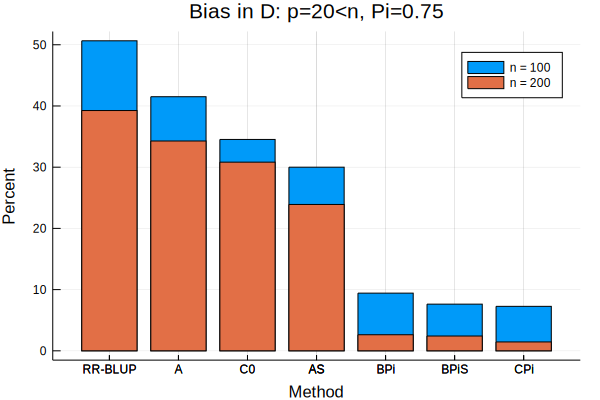

In [136]:
a = [14.47 
     19.43 
     17.93 
     14.85
     14.82 
     14.68 
     18.93
     20.15]
b200 = (a[2:end] .- a[1])./a[1]*100
m = ["A"; "AS"; "BPi";  "BPiS"; "CPi"; "C0"; "RR-BLUP"]
c1 = [b100 b200]
sp = sortperm(c1[:,1],rev=true)
d = c1[sp,:]
x = m[sp]
y = c1[sp,:]
bar(x,y,
    title = "Bias in D: p=20<n, Pi=0.75",
    xlabel = "Method",
    ylabel = "Percent",
    label = ["n = 100" "n = 200"])

In [137]:
savefig("p20bar.png")

### Comparison of BayesA, BayesB, BayesCPi, RR-BLUP and OLS with Sample size n = 100 and number p = 20 of markers and $\pi = 0.9$

In [18]:
probNull = 0.9
n  = 100
p  = 20
N  = 25
Vg = 10
Ve = 10
Random.seed!(1234)
resSim = [getEstimates(n,p,probNull,Vg, Ve) for i=1:N];

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.890941


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.919561


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.026776


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.9686


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.803171
π: 0.696


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.788989
π: 0.694


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.855458
π: 0.615


running MCMC for BayesB... 60%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.838331
π: 0.624


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008254


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.810503
Marker effects variance: 1.569751
π: 0.684

Posterior means at iteration: 

running MCMC for BayesC... 45%|███████████              |  ETA: 0:00:00

10000
Residual variance: 7.80746
Marker effects variance: 1.560803
π: 0.676


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.084577
Marker effects variance: 0.42195

Posterior means at iteration: 10000
Residual variance: 8.077859
Marker effects variance: 0.420131


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004127


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.019515
Marker effects variance: 1.004127


running MCMC for RR-BLUP... 50%|████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.001639
Marker effects variance: 1.004127


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003059


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.638785


running MCMC for BayesB... 30%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.655213


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003059


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.61525


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.636482


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006119


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.699824
π: 0.637

Posterior means at iteration: 10000
Residual variance: 7.685756
π: 0.637


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006119


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.671173
π: 0.599


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.692456
π: 0.597


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.006119


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.660501
Marker effects variance: 1.539964
π: 0.621

Posterior means at iteration: 10000
Residual variance: 7.668869
Marker effects variance: 1.563277
π: 0.633


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003059


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.800091
Marker effects variance: 0.50926

Posterior means at iteration: 10000
Residual variance: 7.800821
Marker effects variance: 0.512637


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003059


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.68245
Marker effects variance: 1.003059


running MCMC for RR-BLUP... 45%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.685871
Marker effects variance: 1.003059


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005915


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.296716

Posterior means at iteration: 10000
Residual variance: 11.269944


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005915


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.273602


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.318663


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01183


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.205027
π: 0.613


running MCMC for BayesB... 50%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.21198
π: 0.62


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01183


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.263158
π: 0.653

Posterior means at iteration: 10000
Residual variance: 11.25694
π: 0.

running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00

653


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01183


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.426707
Marker effects variance: 12.010955
π: 0.78

Posterior means at iteration: 10000
Residual variance: 11.39136
Marker effects variance: 12.113229
π: 0.78


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005915


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.815666
Marker effects variance: 2.739195

Posterior means at iteration: 10000
Residual variance: 11.801495
Marker effects variance: 2.755237


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005915


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.798711
Marker effects variance: 1.005915

Posterior means at iteration: 10000
Residual variance: 12.77591
Marker effects variance: 1.005915


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006016


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.213419

Posterior means at iteration: 10000
Residual variance: 9.192369


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006016


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.362921


running MCMC for BayesB... 46%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.419983


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.335899
π: 0.847


running MCMC for BayesB... 51%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.359992
π: 0.847


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.342885
π: 0.741


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.381249
π: 0.719


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.32021
Marker effects variance: 1.337118
π: 0.815

Posterior means at iteration: 10000
Residual variance: 9.342826
Marker effects variance: 1.339094
π: 0.815


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006016


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.252267
Marker effects variance: 0.258936


running MCMC for BayesC... 15%|████                     |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.254332
Marker effects variance: 0.259093


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006016


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.26089
Marker effects variance: 1.006016

Posterior means at iteration: 10000
Residual variance: 9.268682
Marker effects variance: 1.006016


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.112242

Posterior means at iteration: 10000
Residual variance: 10.09514


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.784646

Posterior means at iteration: 10000
Residual variance: 9.776965


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.015266


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.621454
π: 0.823

Posterior means at iteration: 10000
Residual variance: 9.616402
π: 0.825


running MCMC for BayesB... 54%|█████████████            |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.015266


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 

running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


5000
Residual variance: 9.605911
π: 0.793

Posterior means at iteration: 10000
Residual variance: 9.600637
π: 0.806


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.015266


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.6521
Marker effects variance: 3.54223
π: 0.854

Posterior means at iteration: 10000
Residual variance: 9.646596
Marker effects variance: 3.503746
π: 0.854


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.676756
Marker effects variance: 0.486527

Posterior means at iteration: 10000
Residual variance: 10.6543
Marker effects variance: 0.481763


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007633


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.473091
Marker effects variance: 1.007633

Posterior means at iteration: 10000
Residual variance: 10.480807
Marker effects variance: 1.007633


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005172


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.702838

Posterior means at iteration: 10000
Residual variance: 9.714631


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005172


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.669373


running MCMC for BayesB... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.666453


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010343


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.757217
π: 0.689


running MCMC for BayesB... 27%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.776891
π: 0.684


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010343


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.791287
π: 0.726


running MCMC for BayesB... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.775416
π: 0.73


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010343


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.739097
Marker effects variance: 5.465432
π: 0.782

Posterior means at iteration: 10000
Residual variance: 9.774306
Marker effects variance: 5.340021
π: 0.782


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005172


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.091728
Marker effects variance: 1.188289

Posterior means at iteration: 10000
Residual variance: 10.120443
Marker effects variance: 1.184884


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005172


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.060765
Marker effects variance: 1.005172


running MCMC for RR-BLUP... 47%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.096831
Marker effects variance: 1.005172


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.353004


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.360103


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.285705


running MCMC for BayesB... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.25416


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011678


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.980483
π: 0.71

Posterior means at iteration: 10000
Residual variance: 7.962762
π: 0.708


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011678


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.930565
π: 0.752


running MCMC for BayesB... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.966894
π: 0.752


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011678


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.022451
Marker effects variance: 7.334433
π: 0.795

Posterior means at iteration: 10000
Residual variance: 8.026741
Marker effects variance: 7.426845
π: 0.796


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.793914
Marker effects variance: 1.563287

Posterior means at iteration: 10000
Residual variance: 8.808812
Marker effects variance: 1.565225


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005839


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.978136
Marker effects variance: 1.005839


running MCMC for RR-BLUP... 49%|████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.969786
Marker effects variance: 1.005839


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.085329


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.096988


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.244813


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.218152


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.994555
π: 0.707


running MCMC for BayesB... 31%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.001531
π: 0.703


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.012472
π: 0.681

Posterior means at iteration: 10000
Residual variance: 11.011997
π: 0.678


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.008748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.056256
Marker effects variance: 2.283701
π: 0.72

Posterior means at iteration: 10000
Residual variance: 11.031725
Marker effects variance: 2.320938
π: 0.722


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.661151
Marker effects variance: 0.479021

Posterior means at iteration: 10000
Residual variance: 11.630784
Marker effects variance: 0.478988


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004374


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.16637
Marker effects variance: 1.004374

Posterior means at iteration: 10000
Residual variance: 11.148761
Marker effects variance: 1.004374


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002924


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.104358

Posterior means at iteration: 10000
Residual variance: 10.085142


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002924


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.904528


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.883786


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005847


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.899267
π: 0.787


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.87765
π: 0.783


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005847


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.892596
π: 0.791


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.879693
π: 0.777


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005847


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.957431
Marker effects variance: 9.767052
π: 0.863

Posterior means at iteration: 10000
Residual variance: 9.944019
Marker effects variance: 9.97837
π: 0.864


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002924


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.745806
Marker effects variance: 1.476872


running MCMC for BayesC... 31%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.737747
Marker effects variance: 1.474819


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002924


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.847409
Marker effects variance: 1.002924


running MCMC for RR-BLUP... 52%|█████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.846435
Marker effects variance: 1.002924


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005829


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.656859


running MCMC for BayesB... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.702024


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005829


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.817099


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.810038


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011658


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.056544
π: 0.564


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.084281
π: 0.567


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011658


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.292421
π: 0.589


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.228137
π: 0.586


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.011658


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.76372
Marker effects variance: 11.769787
π: 0.796

Posterior means at iteration: 10000
Residual variance: 9.73942
Marker effects variance: 11.722024
π: 0.793


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005829


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.954101
Marker effects variance: 2.664907

Posterior means at iteration: 10000
Residual variance: 8.989635
Marker effects variance: 2.65891


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005829


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.622879
Marker effects variance: 1.005829

Posterior means at iteration: 10000
Residual variance: 9.650793
Marker effects variance: 1.005829


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00547


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.938362

Posterior means at iteration: 10000
Residual variance: 7.930511


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00547


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.907699


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.901894


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01094


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.780105
π: 0.73


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.797863
π: 0.728


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01094


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.791273
π: 0.728


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.764303
π: 0.729


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01094


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.780795
Marker effects variance: 3.572843
π: 0.774

Posterior means at iteration: 10000
Residual variance: 7.817849
Marker effects variance: 3.590414
π: 0.775


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00547


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.344537
Marker effects variance: 0.746515

Posterior means at iteration: 10000
Residual variance: 8.33675
Marker effects variance: 0.742267


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00547


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.108047
Marker effects variance: 1.00547

Posterior means at iteration: 10000
Residual variance: 8.123443
Marker effects variance: 1.00547


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006867


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.190229

Posterior means at iteration: 10000
Residual variance: 9.175481


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006867


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.377736

Posterior means at iteration: 10000
Residual variance: 9.41845


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013734


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.675703
π: 0.708

Posterior means at iteration: 10000
Residual variance: 9.67552
π: 0.711


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013734


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.751232
π: 0.546

Posterior means at iteration: 10000
Residual variance: 9.669454
π: 0.522


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.013734


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.579208
Marker effects variance: 0.96564
π: 0.598

Posterior means at iteration: 10000
Residual variance: 9.548478
Marker effects variance: 0.980963
π: 0.598


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006867


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.216193
Marker effects variance: 0.322843

Posterior means at iteration: 10000
Residual variance: 9.220751
Marker effects variance: 0.321132


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006867


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.235531
Marker effects variance: 1.006867

Posterior means at iteration: 10000
Residual variance: 9.232181
Marker effects variance: 1.006867


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007481


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.666459


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.704918


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007481


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.714696


running MCMC for BayesB... 46%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.722227


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014961


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.955707
π: 0.744


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.00687
π: 0.745


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014961


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.081785
π: 0.737

Posterior means at iteration: 10000
Residual variance: 11.052834
π: 0.739


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.014961


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.225883
Marker effects variance: 7.673138
π: 0.848

Posterior means at iteration: 10000
Residual variance: 11.223712
Marker effects variance: 7.534642
π: 0.845


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007481


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.27615
Marker effects variance: 1.248694

Posterior means at iteration: 10000
Residual variance: 11.245
Marker effects variance: 1.255276


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.007481


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.356471
Marker effects variance: 1.007481

Posterior means at iteration: 10000
Residual variance: 11.284485
Marker effects variance: 1.007481


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00592


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.9375


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.910875


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00592


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.95294


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.980686


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01184


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.884153
π: 0.808

Posterior means at iteration: 10000
Residual variance: 9.887928
π: 0.803


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01184


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.879674
π: 0.705


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.90661
π: 0.721


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.01184


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.903181
Marker effects variance: 1.747804
π: 0.787

Posterior means at iteration: 10000
Residual variance: 9.90093
Marker effects variance: 1.771583
π: 0.786


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00592


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.069047
Marker effects variance: 0.348327

Posterior means at iteration: 10000
Residual variance: 10.08433
Marker effects variance: 0.34953


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00592


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.995776
Marker effects variance: 1.00592

Posterior means at iteration: 10000
Residual variance: 9.986693
Marker effects variance: 1.00592


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006416


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.100725


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.116693


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006416


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.264904

Posterior means at iteration: 10000
Residual variance: 10.316488


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012832


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.070676
π: 0.676

Posterior means at iteration: 10000
Residual variance: 10.09057
π: 0.682


running MCMC for BayesB... 55%|██████████████           |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012832


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.170757
π: 0.538

Posterior means at iteration: 10000
Residual variance: 10.163207
π: 0.557


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.012832


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.114446
Marker effects variance: 1.259196
π: 0.639

Posterior means at iteration: 10000
Residual variance: 10.110192
Marker effects variance: 1.237538
π: 0.635


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006416


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.360869
Marker effects variance: 0.373909

Posterior means at iteration: 10000
Residual variance: 10.317894
Marker effects variance: 0.369459


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.006416


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.141269
Marker effects variance: 1.006416

Posterior means at iteration: 10000
Residual variance: 10.198145
Marker effects variance: 1.006416


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005086


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.90159

Posterior means at iteration: 10000
Residual variance: 9.88688


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005086


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.943933

Posterior means at iteration: 10000
Residual variance: 9.923576


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010171


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.860309
π: 0.673

Posterior means at iteration: 10000
Residual variance: 9.837224
π: 0.673


running MCMC for BayesB... 49%|████████████             |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010171


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.843022
π: 0.68

Posterior means at iteration: 10000
Residual variance: 9.862398
π: 0.687


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.010171


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.914791
Marker effects variance: 3.107991
π: 0.73

Posterior means at iteration: 10000
Residual variance: 9.897274
Marker effects variance: 3.058991
π: 0.731


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005086


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.325539
Marker effects variance: 0.731151

Posterior means at iteration: 10000
Residual variance: 10.331468
Marker effects variance: 0.73098


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.005086


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.097935
Marker effects variance: 1.005086

Posterior means at iteration: 10000
Residual variance: 10.11131
Marker effects variance: 1.005086


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004985


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.016238

Posterior means at iteration: 10000
Residual variance: 10.020661


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004985


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.963483

Posterior means at iteration: 10000
Residual variance: 9.947233


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009969


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.907672
π: 0.685

Posterior means at iteration: 10000
Residual variance: 9.894612
π: 0.682


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009969


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.812213
π: 0.701

Posterior means at iteration: 10000
Residual variance: 9.833637
π: 0.701


running MCMC for BayesB... 50%|█████████████            |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009969


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.930509
Marker effects variance: 3.632591
π: 0.743

Posterior means at iteration: 10000
Residual variance: 9.917226
Marker effects variance: 3.680959
π: 0.746


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004985


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.555465
Marker effects variance: 0.822665

Posterior means at iteration: 10000
Residual variance: 10.561362
Marker effects variance: 0.825301


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004985


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.331707
Marker effects variance: 1.004985

Posterior means at iteration: 10000
Residual variance: 10.32812
Marker effects variance: 1.004985


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004858


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.481939

Posterior means at iteration: 10000
Residual variance: 8.470572


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004858


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.615327


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.638853


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009717


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.072613
π: 0.724

Posterior means at iteration: 10000
Residual variance: 9.07889
π: 0.725


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009717


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.10419
π: 0.671


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.089209
π: 0.65


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009717


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.159699
Marker effects variance: 2.342709
π: 0.745

Posterior means at iteration: 10000
Residual variance: 9.165613
Marker effects variance: 2.323078
π: 0.738


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004858


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.805341
Marker effects variance: 0.595647

Posterior means at iteration: 10000
Residual variance: 8.784619
Marker effects variance: 0.591091


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004858


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.505485
Marker effects variance: 1.004858

Posterior means at iteration: 10000
Residual variance: 8.527082
Marker effects variance: 1.004858


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00389


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.663566

Posterior means at iteration: 10000
Residual variance: 10.66894


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00389


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.751732


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.74402


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00778


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.601858
π: 0.653

Posterior means at iteration: 10000
Residual variance: 10.60725
π: 0.647


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00778


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.640648
π: 0.638


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.640622
π: 0.653


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00778


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.671647
Marker effects variance: 3.245376
π: 0.718

Posterior means at iteration: 10000
Residual variance: 10.684256
Marker effects variance: 3.31072
π: 0.721


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00389


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.184884
Marker effects variance: 0.804823

Posterior means at iteration: 10000
Residual variance: 11.170264
Marker effects variance: 0.802536


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00389


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.987334
Marker effects variance: 1.00389

Posterior means at iteration: 10000
Residual variance: 10.978674
Marker effects variance: 1.00389


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.97657

Posterior means at iteration: 10000
Residual variance: 8.987277


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.227613


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.206592


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005495


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.614857
π: 0.648

Posterior means at iteration: 10000
Residual variance: 9.630673
π: 0.65


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005495


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.506697
π: 0.456


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.517666
π: 0.447


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005495


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.441324
Marker effects variance: 0.803538
π: 0.496

Posterior means at iteration: 10000
Residual variance: 9.442304
Marker effects variance: 0.814853
π: 0.507


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.029237
Marker effects variance: 0.318864

Posterior means at iteration: 10000
Residual variance: 9.022258
Marker effects variance: 0.31687


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002748


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.024309
Marker effects variance: 1.002748

Posterior means at iteration: 10000
Residual variance: 9.035264
Marker effects variance: 1.002748


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003673


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.67539

Posterior means at iteration: 10000
Residual variance: 8.662617


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003673


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.81259

Posterior means at iteration: 10000
Residual variance: 8.777097


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007347


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.163608
π: 0.511

Posterior means at iteration: 10000
Residual variance: 9.176622
π: 0.51


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007347


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.331443
π: 0.521


running MCMC for BayesB... 46%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.236372
π: 0.489


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007347


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.462974
Marker effects variance: 3.018419
π: 0.606

Posterior means at iteration: 10000
Residual variance: 9.489405
Marker effects variance: 3.102715
π: 0.615


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003673


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.723395
Marker effects variance: 1.164912

Posterior means at iteration: 10000
Residual variance: 8.782892
Marker effects variance: 1.146014


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003673


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.736476
Marker effects variance: 1.003673

Posterior means at iteration: 10000
Residual variance: 8.727383
Marker effects variance: 1.003673


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002959


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.009937


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.983404


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002959


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.162971


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.185765


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005917


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.473223
π: 0.867


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.474911
π: 0.866


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005917


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.372668
π: 0.646


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.35594
π: 0.669


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005917


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.415588
Marker effects variance: 1.329953
π: 0.811

Posterior means at iteration: 10000
Residual variance: 9.390031
Marker effects variance: 1.27738
π: 0.81


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002959


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.941231
Marker effects variance: 0.248755

Posterior means at iteration: 10000
Residual variance: 8.94815
Marker effects variance: 0.247469


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002959


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.105263
Marker effects variance: 1.002959

Posterior means at iteration: 10000
Residual variance: 9.109437
Marker effects variance: 1.002959


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004662


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.38287

Posterior means at iteration: 10000
Residual variance: 9.35222


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004662


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.313077


running MCMC for BayesB... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.347585


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009323


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.650293
π: 0.75


running MCMC for BayesB... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.661856
π: 0.751


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009323


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.658738
π: 0.727


running MCMC for BayesB... 60%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.67597
π: 0.729


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.009323


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.73521
Marker effects variance: 4.915673
π: 0.823

Posterior means at iteration: 10000
Residual variance: 9.764081
Marker effects variance: 4.793361
π: 0.826


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004662


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.966784
Marker effects variance: 0.762976

Posterior means at iteration: 10000
Residual variance: 9.930636
Marker effects variance: 0.767497


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.004662


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.747444
Marker effects variance: 1.004662

Posterior means at iteration: 10000
Residual variance: 9.748092
Marker effects variance: 1.004662


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002652


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.756514


running MCMC for BayesB... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.73992


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002652


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.865986


running MCMC for BayesB... 61%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.931804


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005304


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.301488
π: 0.861


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 13.269853
π: 0.859


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005304


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.190684
π: 0.638


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 13.177392
π: 0.657


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.005304


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 13.209892
Marker effects variance: 1.253174
π: 0.797

Posterior means at iteration: 10000
Residual variance: 13.191571
Marker effects variance: 1.264653
π: 0.794


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002652


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.683051
Marker effects variance: 0.274137

Posterior means at iteration: 10000
Residual variance: 12.690479
Marker effects variance: 0.274643


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.002652


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 12.804493
Marker effects variance: 1.002652

Posterior means at iteration: 10000
Residual variance: 12.808198
Marker effects variance: 1.002652


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003996


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.832032


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.822902


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003996


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.849287


running MCMC for BayesB... 31%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.846621


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007992


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 7.99873
π: 0.674


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.989905
π: 0.678


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007992


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.017194
π: 0.685


running MCMC for BayesB... 30%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.028444
π: 0.677


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.007992


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.105135
Marker effects variance: 6.912202
π: 0.797

Posterior means at iteration: 10000
Residual variance: 8.122718
Marker effects variance: 6.848157
π: 0.797


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003996


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.174515
Marker effects variance: 1.416809

Posterior means at iteration: 10000
Residual variance: 8.181076
Marker effects variance: 1.421361


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.003996


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.228232
Marker effects variance: 1.003996

Posterior means at iteration: 10000
Residual variance: 8.23889
Marker effects variance: 1.003996


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


In [19]:
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result1 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end
println("------------------------------------------")
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result2 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end

     True value            9.83  +/- 0.199 
     BayesA Scale known   18.02  +/- 0.196 
     BayesA Scale unknown 14.93  +/- 0.259 
     BayesB Scale known   11.49  +/- 0.234 
     BayesB Scale unknown 11.39  +/- 0.223 
     BayesCPi             10.90  +/- 0.198 
     BayesC0              17.27  +/- 0.269 
     RRBLUP               19.14  +/- 0.169 
------------------------------------------
     True value            9.83  +/- 0.199 
     BayesA Scale known   23.42  +/- 0.191 
     BayesA Scale unknown 19.73  +/- 0.270 
     BayesB Scale known   12.38  +/- 0.243 
     BayesB Scale unknown 12.55  +/- 0.220 
     BayesCPi             11.62  +/- 0.194 
     BayesC0              22.73  +/- 0.274 
     RRBLUP               24.81  +/- 0.161 


In [20]:
biasMat = [row.estimates[i].result1 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  8.1832   0.0929869
 "BayesA Scale unknown"  5.092    0.113455 
 "BayesB Scale known  "  1.65545  0.101728 
 "BayesB Scale unknown"  1.5603   0.0946289
 "BayesCPi            "  1.06901  0.0918077
 "BayesC0             "  7.43688  0.131922 
 "RRBLUP              "  9.3031   0.101869 

In [21]:
biasMat = [row.estimates[i].result2 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  13.587    0.078213 
 "BayesA Scale unknown"   9.90064  0.115269 
 "BayesB Scale known  "   2.55057  0.110096 
 "BayesB Scale unknown"   2.72061  0.102823 
 "BayesCPi            "   1.78703  0.101262 
 "BayesC0             "  12.8998   0.125114 
 "RRBLUP              "  14.9816   0.0906109

### Comparison of BayesA, BayesB, BayesCPi, RR-BLUP and OLS with Sample size n = 500 and number p = 20 of markers and $\pi = 0.9$

In [22]:
probNull = 0.9
n  = 500
p  = 20
N  = 25
Vg = 10
Ve = 10
Random.seed!(1234)
resSim = [getEstimates(n,p,probNull,Vg, Ve) for i=1:N];

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000977


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 16%|████                     |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.972806


running MCMC for BayesB... 68%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.977901


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000977


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.975782


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.960583


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001954


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.985145
π: 0.803


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.993929
π: 0.804


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001954


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.003351
π: 0.797


running MCMC for BayesB... 65%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.002606
π: 0.801


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001954


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.004202
Marker effects variance: 4.890216
π: 0.835


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.005604
Marker effects variance: 4.870474
π: 0.836


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000977


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.999268
Marker effects variance: 0.925729


running MCMC for BayesC... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.994968
Marker effects variance: 0.922852


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000977


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.989902
Marker effects variance: 1.000977


running MCMC for RR-BLUP... 32%|████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.99262
Marker effects variance: 1.000977


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000761


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.451002


running MCMC for BayesB... 58%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.461848


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000761


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.418134


running MCMC for BayesB... 29%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.418469


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001523


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 22%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 9.550563
π: 0.775


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.565302
π: 0.777


running MCMC for BayesB... 64%|████████████████         |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001523


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.578057
π: 0.799


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.57072
π: 0.792


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001523


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.562129
Marker effects variance: 10.289696
π: 0.839


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.575716
Marker effects variance: 10.3873
π: 0.837


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000761


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.477759
Marker effects variance: 2.095909


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.468981
Marker effects variance: 2.092094


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000761


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.480459
Marker effects variance: 1.000761


running MCMC for RR-BLUP... 45%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.489596
Marker effects variance: 1.000761


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000535


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.971176


running MCMC for BayesB... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.965612


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000535


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.877166


running MCMC for BayesB... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.882014


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001071


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.882371
π: 0.875


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.87671
π: 0.875


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001071


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.882952
π: 0.862


running MCMC for BayesB... 67%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.877237
π: 0.861


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001071


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.869377
Marker effects variance: 1.905672
π: 0.877


running MCMC for BayesC... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.873713
Marker effects variance: 1.869145
π: 0.875


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000535


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.009561
Marker effects variance: 0.224097


running MCMC for BayesC... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.989639
Marker effects variance: 0.224134


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000535


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.980086
Marker effects variance: 1.000535

Posterior means at iteration: 10000
Residual variance: 10.99629
Marker effects variance: 1.000535


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001474


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.840236


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.841141


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001474


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 16%|████                     |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.809787


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.818239


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002947


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.879635
π: 0.754


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.876453
π: 0.751


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002947


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.884936
π: 0.759


running MCMC for BayesB... 58%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.888651
π: 0.754


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002947


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.896885
Marker effects variance: 3.455653
π: 0.786


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.899906
Marker effects variance: 3.451722
π: 0.784


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001474


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.866772
Marker effects variance: 0.786123


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.869041
Marker effects variance: 0.779398


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001474


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 8.867869
Marker effects variance: 1.001474


running MCMC for RR-BLUP... 64%|███████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.862647
Marker effects variance: 1.001474


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001179


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 20%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.26793


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.247028


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001179


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 19%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.210264


running MCMC for BayesB... 58%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.20987


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002358


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.279113
π: 0.851


running MCMC for BayesB... 58%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.285376
π: 0.854


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002358


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.267843
π: 0.847


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.2792
π: 0.849


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002358


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.313557
Marker effects variance: 5.886089
π: 0.88


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.305295
Marker effects variance: 5.956535
π: 0.881


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001179


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.298016
Marker effects variance: 0.862863


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.286681
Marker effects variance: 0.860053


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001179


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.27743
Marker effects variance: 1.001179

Posterior means at iteration: 10000
Residual variance: 10.279151
Marker effects variance: 1.001179


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00072


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 22%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 9.428751


running MCMC for BayesB... 67%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.429355


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00072


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 17%|████                     |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 9.37902


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.384364


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00144


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 12%|███                      |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.37957
π: 0.813


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.381041
π: 0.811


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00144


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.384706
π: 0.795


running MCMC for BayesB... 61%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.375749
π: 0.798


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00144


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.387143
Marker effects variance: 1.704531
π: 0.812

Posterior means at iteration: 10000
Residual variance: 9.38355
Marker effects variance: 1.763748
π: 0.815


running MCMC for BayesC... 46%|███████████              |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00072


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.451423
Marker effects variance: 0.30369


running MCMC for BayesC... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.437064
Marker effects variance: 0.304036


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.00072


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.449847
Marker effects variance: 1.00072


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.441443
Marker effects variance: 1.00072


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001313


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.068935


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.078817


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001313


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.070895


running MCMC for BayesB... 58%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.063545


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002625


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.223433
π: 0.719


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.222449
π: 0.718


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002625


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.220418
π: 0.741


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.235321
π: 0.744


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002625


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.305339
Marker effects variance: 4.628855
π: 0.784


running MCMC for BayesC... 25%|██████                   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.283807
Marker effects variance: 4.564634
π: 0.783


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001313


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.102969
Marker effects variance: 1.066784


running MCMC for BayesC... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.099032
Marker effects variance: 1.068613


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001313


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.09402
Marker effects variance: 1.001313

Posterior means at iteration: 10000
Residual variance: 10.098307
Marker effects variance: 1.001313


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000876


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.310564


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.31572


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000876


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.271237


running MCMC for BayesB... 71%|██████████████████       |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.269487


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001751


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 22%|██████                   |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.287303
π: 0.811


running MCMC for BayesB... 64%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.289845
π: 0.811


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001751


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 20%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.272766
π: 0.785


running MCMC for BayesB... 64%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.27837
π: 0.785


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001751


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.287821
Marker effects variance: 1.644188
π: 0.809


running MCMC for BayesC... 62%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.284932
Marker effects variance: 1.657114
π: 0.808


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000876


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.339336
Marker effects variance: 0.297584


running MCMC for BayesC... 28%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.328482
Marker effects variance: 0.296147


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000876


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.324764
Marker effects variance: 1.000876


running MCMC for RR-BLUP... 46%|███████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.322375
Marker effects variance: 1.000876


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000926


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.25101


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.243523


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000926


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.194615


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.18516


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001853


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.064951
π: 0.771


running MCMC for BayesB... 71%|██████████████████       |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.072019
π: 0.77


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001853


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 19%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.079588
π: 0.789


running MCMC for BayesB... 73%|██████████████████       |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.072636
π: 0.786


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001853


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.088442
Marker effects variance: 6.060889
π: 0.806


running MCMC for BayesC... 57%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.101413
Marker effects variance: 5.904072
π: 0.804


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000926


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.257182
Marker effects variance: 1.301057


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.25924
Marker effects variance: 1.293445


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000926


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.295921
Marker effects variance: 1.000926


running MCMC for RR-BLUP... 30%|███████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.278662
Marker effects variance: 1.000926


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001586


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.636701


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.648531


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001586


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 29%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.561862


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.581004


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003172


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.531471
π: 0.82


running MCMC for BayesB... 30%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.522863
π: 0.82


running MCMC for BayesB... 65%|████████████████         |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003172


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00



Posterior means at iteration: 5000
Residual variance: 10.536923
π: 0.836


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.539091
π: 0.837


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.003172


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.524221
Marker effects variance: 15.268953
π: 0.851

Posterior means at iteration: 10000
Residual variance: 10.521868
Marker effects variance: 15.40474
π: 0.851


running MCMC for BayesC... 44%|███████████              |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001586


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.68365
Marker effects variance: 2.859734


running MCMC for BayesC... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.697634
Marker effects variance: 2.859889


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001586


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.726567
Marker effects variance: 1.001586


running MCMC for RR-BLUP... 59%|██████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.722195
Marker effects variance: 1.001586


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000952


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.866401


running MCMC for BayesB... 49%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.865088


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000952


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.773698


running MCMC for BayesB... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.768284


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001903


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.64412
π: 0.83


running MCMC for BayesB... 57%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.653107
π: 0.828


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001903


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.644042
π: 0.839


running MCMC for BayesB... 60%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.646338
π: 0.84


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001903


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.633809
Marker effects variance: 9.928865
π: 0.85


running MCMC for BayesC... 50%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.635161
Marker effects variance: 9.977777
π: 0.849


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000952


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.911243
Marker effects variance: 1.826343


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.903267
Marker effects variance: 1.823951


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000952


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.897503
Marker effects variance: 1.000952


running MCMC for RR-BLUP... 54%|█████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.903135
Marker effects variance: 1.000952


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001111


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 21%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 11.219238


running MCMC for BayesB... 62%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.216334


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001111


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB...  0%|                         |  ETA: 0:00:47


Posterior means at iteration: 5000
Residual variance: 11.170447


running MCMC for BayesB... 51%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.166981


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002222


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.101935
π: 0.813


running MCMC for BayesB... 38%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.098263
π: 0.812


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002222


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.110911
π: 0.813


running MCMC for BayesB... 55%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.109956
π: 0.816


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002222


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.090936
Marker effects variance: 4.1756
π: 0.834


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.097545
Marker effects variance: 4.10756
π: 0.835


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001111


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.265135
Marker effects variance: 0.747706


running MCMC for BayesC... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.264559
Marker effects variance: 0.748808


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001111


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.223453
Marker effects variance: 1.001111


running MCMC for RR-BLUP... 62%|███████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.237129
Marker effects variance: 1.001111


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000663


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.827927


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.850656


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000663


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.855824


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.842254


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001326


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.97459
π: 0.802


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.985723
π: 0.803


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001326


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.005939
π: 0.78


running MCMC for BayesB... 50%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.989104
π: 0.762


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001326


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.052227
Marker effects variance: 5.621128
π: 0.856


running MCMC for BayesC... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.054223
Marker effects variance: 5.498532
π: 0.853


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000663


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.87863
Marker effects variance: 0.911566


running MCMC for BayesC... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.873081
Marker effects variance: 0.911549


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000663


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.878678
Marker effects variance: 1.000663


running MCMC for RR-BLUP... 64%|███████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.87271
Marker effects variance: 1.000663


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000954


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 16%|████                     |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.369195


running MCMC for BayesB... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.366916


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000954


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 19%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.347441


running MCMC for BayesB... 57%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.341479


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:01


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001907


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.368055
π: 0.778


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.362582
π: 0.778


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001907


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.359069
π: 0.76


running MCMC for BayesB... 68%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.367523
π: 0.761


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001907


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.354649
Marker effects variance: 2.174593
π: 0.792


running MCMC for BayesC... 30%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.368732
Marker effects variance: 2.181531
π: 0.792


running MCMC for BayesC... 64%|████████████████         |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000954


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.384331
Marker effects variance: 0.44354


running MCMC for BayesC... 45%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.39115
Marker effects variance: 0.442978


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000954


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.397068
Marker effects variance: 1.000954


running MCMC for RR-BLUP... 59%|██████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.399104
Marker effects variance: 1.000954


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000527


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.937303


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.937961


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000527


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.885525


running MCMC for BayesB... 58%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.904467


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001054


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.988842
π: 0.786


running MCMC for BayesB... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.995882
π: 0.787


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001054


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.9829
π: 0.796


running MCMC for BayesB... 68%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.987415
π: 0.799


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001054


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.986069
Marker effects variance: 3.508071
π: 0.816


running MCMC for BayesC... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.987551
Marker effects variance: 3.575218
π: 0.818


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000527


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.970696
Marker effects variance: 0.697697


running MCMC for BayesC... 29%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.971526
Marker effects variance: 0.693801


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000527


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.961033
Marker effects variance: 1.000527


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.956301
Marker effects variance: 1.000527


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000746


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 22%|██████                   |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.728033


running MCMC for BayesB... 63%|████████████████         |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.731137


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000746


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.719692


running MCMC for BayesB... 55%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.71738


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001492


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.822038
π: 0.76


running MCMC for BayesB... 28%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.827953
π: 0.764


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001492


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.826897
π: 0.758


running MCMC for BayesB... 29%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.843425
π: 0.757


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001492


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.949926
Marker effects variance: 16.221788
π: 0.852


running MCMC for BayesC... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.960503
Marker effects variance: 16.259483
π: 0.852


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000746


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.75027
Marker effects variance: 2.943647


running MCMC for BayesC... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.756458
Marker effects variance: 2.941965


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000746


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.800289
Marker effects variance: 1.000746


running MCMC for RR-BLUP... 40%|█████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.812155
Marker effects variance: 1.000746


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.03539


running MCMC for BayesB... 55%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.03638


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.948984


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.948324


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002209


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.896996
π: 0.821


running MCMC for BayesB... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.897055
π: 0.821


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002209


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.885327
π: 0.834


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.880138
π: 0.832


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002209


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.869108
Marker effects variance: 4.366245
π: 0.842


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.878866
Marker effects variance: 4.414707
π: 0.841


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.063034
Marker effects variance: 0.780629


running MCMC for BayesC... 36%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.06357
Marker effects variance: 0.776386


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.046041
Marker effects variance: 1.001105


running MCMC for RR-BLUP... 39%|█████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.058436
Marker effects variance: 1.001105


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001037


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 21%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 9.686326


running MCMC for BayesB... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.684995


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001037


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.623021


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.61467


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002074


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.566491
π: 0.819


running MCMC for BayesB... 48%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.563856
π: 0.817


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002074


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.560542
π: 0.836


running MCMC for BayesB... 54%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.573008
π: 0.837


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002074


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.58758
Marker effects variance: 10.78982
π: 0.846

Posterior means at iteration: 10000
Residual variance: 9.570077
Marker effects variance: 10.65283
π: 0.848


running MCMC for BayesC... 46%|████████████             |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001037


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.696096
Marker effects variance: 1.915522

Posterior means at iteration: 

running MCMC for BayesC... 45%|███████████              |  ETA: 0:00:00

10000
Residual variance: 9.703656
Marker effects variance: 1.918166


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001037


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.724113
Marker effects variance: 1.001037

Posterior means at iteration: 10000
Residual variance: 9.726769
Marker effects variance: 1.001037


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.046198


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.047135


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.040144


running MCMC for BayesB... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.032002


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001637


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 18%|████                     |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 11.039085
π: 0.792


running MCMC for BayesB... 61%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.036808
π: 0.792


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001637


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.036192
π: 0.78


running MCMC for BayesB... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.035971
π: 0.78


running MCMC for BayesB... 67%|█████████████████        |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001637


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.05061
Marker effects variance: 1.834969
π: 0.798


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.041179
Marker effects variance: 1.837945
π: 0.796


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 26%|██████                   |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 11.066073
Marker effects variance: 0.338406


running MCMC for BayesC... 59%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.074463
Marker effects variance: 0.338913


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000818


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 11.077984
Marker effects variance: 1.000818


running MCMC for RR-BLUP... 60%|██████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.081933
Marker effects variance: 1.000818


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000953


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.244809


running MCMC for BayesB... 54%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.239828


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000953


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.203024


running MCMC for BayesB... 60%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.205194


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001906


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.247916
π: 0.771


running MCMC for BayesB... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.23826
π: 0.769


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001906


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.257262
π: 0.791


running MCMC for BayesB... 49%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.255558
π: 0.785


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001906


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.262506
Marker effects variance: 4.550822
π: 0.805


running MCMC for BayesC... 35%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.262833
Marker effects variance: 4.600689
π: 0.807


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000953


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.255765
Marker effects variance: 0.951277


running MCMC for BayesC... 34%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.262415
Marker effects variance: 0.947605


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000953


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.26244
Marker effects variance: 1.000953


running MCMC for RR-BLUP... 39%|█████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.265087
Marker effects variance: 1.000953


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000898


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.150559


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.154826


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000898


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 24%|██████                   |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.116412


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.108479


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001795


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.065059
π: 0.809


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.075672
π: 0.809


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001795


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.078959
π: 0.808


running MCMC for BayesB... 52%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.078906
π: 0.802


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001795


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 18%|█████                    |  ETA: 0:00:00


Posterior means at iteration: 5000
Residual variance: 10.059693
Marker effects variance: 2.068745
π: 0.816


running MCMC for BayesC... 44%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.076361
Marker effects variance: 2.043847
π: 0.815


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000898


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.179681
Marker effects variance: 0.353576


running MCMC for BayesC... 50%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.167515
Marker effects variance: 0.353569


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000898


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.159274
Marker effects variance: 1.000898


running MCMC for RR-BLUP... 28%|███████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.164352
Marker effects variance: 1.000898


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001042


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.923619


running MCMC for BayesB... 47%|████████████             |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.918592


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001042


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.84355


running MCMC for BayesB... 51%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.831379


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002085


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.673655
π: 0.83


running MCMC for BayesB... 67%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.695458
π: 0.828


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002085


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.686723
π: 0.837


running MCMC for BayesB... 56%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.696198
π: 0.838


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.002085


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.682397
Marker effects variance: 6.456702
π: 0.847


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.686177
Marker effects variance: 6.414728
π: 0.847


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001042


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.94933
Marker effects variance: 1.154948


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.948843
Marker effects variance: 1.158662


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001042


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.970162
Marker effects variance: 1.001042


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.965741
Marker effects variance: 1.001042


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000466


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.212771


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.2041


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000466


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.145465


running MCMC for BayesB... 53%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.14635


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.000932


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.225158
π: 0.792


running MCMC for BayesB... 33%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.219034
π: 0.789


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.000932


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.228037
π: 0.804


running MCMC for BayesB... 46%|███████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.220192
π: 0.795


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.000932


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.223399
Marker effects variance: 3.592251
π: 0.819


running MCMC for BayesC... 26%|███████                  |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.231993
Marker effects variance: 3.611248
π: 0.82


running MCMC for BayesC... 55%|██████████████           |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000466


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.219352
Marker effects variance: 0.679575


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.232562
Marker effects variance: 0.679939


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000466


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.22322
Marker effects variance: 1.000466


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.229726
Marker effects variance: 1.000466


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000774


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.700114


running MCMC for BayesB... 54%|█████████████            |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.705132


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000774


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.635047


running MCMC for BayesB... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.645755


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001548


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.683159
π: 0.792


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.677517
π: 0.791


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001548


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.671583
π: 0.805


running MCMC for BayesB... 58%|███████████████          |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.667013
π: 0.799


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.001548


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.680188
Marker effects variance: 6.065305
π: 0.827


running MCMC for BayesC... 34%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.678125
Marker effects variance: 6.120054
π: 0.829


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000774


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.718203
Marker effects variance: 1.17455


running MCMC for BayesC... 32%|████████                 |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.727237
Marker effects variance: 1.182511


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.000774


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 9.725872
Marker effects variance: 1.000774

Posterior means at iteration: 10000
Residual variance: 9.729381
Marker effects variance: 1.000774


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001835


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.094372


running MCMC for BayesB... 38%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.097766


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001835


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.046862


running MCMC for BayesB... 57%|██████████████           |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.056522


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00367


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.058992
π: 0.79


running MCMC for BayesB... 37%|█████████                |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.06807
π: 0.789


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00367


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.082437
π: 0.799


running MCMC for BayesB... 70%|█████████████████        |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.088499
π: 0.8


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 2.00367


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.161936
Marker effects variance: 15.488985
π: 0.862

Posterior means at iteration: 10000
Residual variance: 10.163627
Marker effects variance: 15.341715
π: 0.862


running MCMC for BayesC... 45%|███████████              |  ETA: 0:00:00

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001835


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.131429
Marker effects variance: 2.551614


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.120975
Marker effects variance: 2.545682


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:00


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
20 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 1.001835


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.

Posterior means at iteration: 5000
Residual variance: 10.145493
Marker effects variance: 1.001835

Posterior means at iteration: 10000


running MCMC for RR-BLUP... 45%|███████████             |  ETA: 0:00:00

Residual variance: 10.15761
Marker effects variance: 1.001835


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:00


In [23]:
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result1 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end
println("------------------------------------------")
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result2 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end

     True value           11.25  +/- 0.167 
     BayesA Scale known   16.26  +/- 0.174 
     BayesA Scale unknown 14.60  +/- 0.184 
     BayesB Scale known   11.84  +/- 0.181 
     BayesB Scale unknown 11.81  +/- 0.179 
     BayesCPi             11.55  +/- 0.175 
     BayesC0              16.09  +/- 0.186 
     RRBLUP               16.29  +/- 0.165 
------------------------------------------
     True value           11.25  +/- 0.167 
     BayesA Scale known   18.78  +/- 0.175 
     BayesA Scale unknown 16.85  +/- 0.186 
     BayesB Scale known   11.98  +/- 0.182 
     BayesB Scale unknown 11.94  +/- 0.178 
     BayesCPi             11.63  +/- 0.175 
     BayesC0              18.62  +/- 0.189 
     RRBLUP               18.83  +/- 0.167 


In [27]:
biasMat = [row.estimates[i].result1 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  5.00976   0.0552595
 "BayesA Scale unknown"  3.35101   0.0549098
 "BayesB Scale known  "  0.592547  0.0347821
 "BayesB Scale unknown"  0.557722  0.0331774
 "BayesCPi            "  0.302329  0.0287995
 "BayesC0             "  4.83884   0.0612661
 "RRBLUP              "  5.03921   0.0574474

In [28]:
biasMat = [row.estimates[i].result2 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  7.5312    0.0409828
 "BayesA Scale unknown"  5.60205   0.0466471
 "BayesB Scale known  "  0.732082  0.035232 
 "BayesB Scale unknown"  0.692376  0.0334819
 "BayesCPi            "  0.37853   0.0289233
 "BayesC0             "  7.37529   0.0491975
 "RRBLUP              "  7.58588   0.0414291

### Comparison of BayesA, BayesB, BayesCPi, RR-BLUP and OLS with Sample size n = 100 and number p = 1000 of markers and $\pi=0.99$

In [33]:
probNull = 0.99
n  = 100
p  = 1000
N  = 25
Vg = 10
Ve = 10
Random.seed!(1234)
resSim = [getEstimates(n,p,probNull,Vg, Ve) for i=1:N];

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 13.600048


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 13.29576


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.015243


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.75985


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.446603
π: 0.333


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.943556
π: 0.365


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.058431
π: 0.614


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.460182
π: 0.785


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 13.341709
Marker effects variance: 0.048984
π: 0.435


running MCMC for BayesC... 83%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 13.530053
Marker effects variance: 0.246689
π: 0.604


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 14.068218
Marker effects variance: 0.02309


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 16.017962
Marker effects variance: 0.018782


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 36%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 14.832414
Marker effects variance: 0.020101


running MCMC for RR-BLUP... 84%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 14.988521
Marker effects variance: 0.020101


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.890538


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.828491


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 3.979883


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.133465


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040191


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.156148
π: 0.211


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.206274
π: 0.242


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040191


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.712431
π: 0.895


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.395399
π: 0.919


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040191


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 5.835869
Marker effects variance: 0.241421
π: 0.735


running MCMC for BayesC... 83%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.351602
Marker effects variance: 0.246187
π: 0.733


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.812782
Marker effects variance: 0.028163


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.116189
Marker effects variance: 0.031924


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 36%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 12.691221
Marker effects variance: 0.020096


running MCMC for RR-BLUP... 84%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.663847
Marker effects variance: 0.020096


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020106


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.595767


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.580813


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020106


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.759408


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.722188


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040211


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.092899
π: 0.448


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.698917
π: 0.343


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040211


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.29733
π: 0.828


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.174481
π: 0.551


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040211


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 5.824988
Marker effects variance: 0.034754
π: 0.27


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.947009
Marker effects variance: 0.044547
π: 0.339


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020106


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.727333
Marker effects variance: 0.022597


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.601708
Marker effects variance: 0.023205


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020106


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 35%|████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.075353
Marker effects variance: 0.020106


running MCMC for RR-BLUP... 79%|███████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.050482
Marker effects variance: 0.020106


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020102


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.281042


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.120722


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020102


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.265082


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 3.986372


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040205


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.431464
π: 0.261


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.996299
π: 0.224


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040205


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.82502
π: 0.872


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.686436
π: 0.913


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040205


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 5.906741
Marker effects variance: 0.06016
π: 0.367


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.157875
Marker effects variance: 0.05538
π: 0.295


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020102


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.114653
Marker effects variance: 0.030249


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.712877
Marker effects variance: 0.030736


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020102


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 35%|████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.471528
Marker effects variance: 0.020102


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.492723
Marker effects variance: 0.020102


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.391601


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.307598


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.633833


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.394105


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040194


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.39277
π: 0.519


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.291075
π: 0.526


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040194


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.124334
π: 0.882


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.397097
π: 0.92


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040194


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 6.637431
Marker effects variance: 0.099231
π: 0.435


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.853027
Marker effects variance: 0.084571
π: 0.509


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.039019
Marker effects variance: 0.020471


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.917129
Marker effects variance: 0.020884


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.708574
Marker effects variance: 0.020097


running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.618543
Marker effects variance: 0.020097


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 14.468652


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 14.283847


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.870774


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.546132


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 12.251473
π: 0.382


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.454836
π: 0.383


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 14.556852
π: 0.462


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 13.505107
π: 0.426


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 15.921065
Marker effects variance: 0.032774
π: 0.426


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 15.094777
Marker effects variance: 0.031272
π: 0.357


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 18.419063
Marker effects variance: 0.011918


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 17.323348
Marker effects variance: 0.014296


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 14.486848
Marker effects variance: 0.0201


running MCMC for RR-BLUP... 85%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 14.394754
Marker effects variance: 0.0201


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.697474


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.639983


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.746918


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.992886


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040191


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.587942
π: 0.543


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.112265
π: 0.593


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040191


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.253639
π: 0.782


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.603577
π: 0.839


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040191


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.532554
Marker effects variance: 0.033238
π: 0.485


running MCMC for BayesC... 80%|████████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.45378
Marker effects variance: 0.037971
π: 0.591


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.510006
Marker effects variance: 0.012425


running MCMC for BayesC... 82%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.243783
Marker effects variance: 0.012967


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 37%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 5.330812
Marker effects variance: 0.020096


running MCMC for RR-BLUP... 85%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.367508
Marker effects variance: 0.020096


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 12.646812


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.628418


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.712837


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.087481


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.731081
π: 0.321


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.543818
π: 0.358


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.357101
π: 0.483


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.143939
π: 0.671


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 11.224372
Marker effects variance: 0.03974
π: 0.364


running MCMC for BayesC... 82%|████████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.09402
Marker effects variance: 0.047896
π: 0.403


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 13.053428
Marker effects variance: 0.020559


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.830281
Marker effects variance: 0.021406


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 37%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 12.846838
Marker effects variance: 0.020101


running MCMC for RR-BLUP... 85%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.813758
Marker effects variance: 0.020101


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020103


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.353507


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.97787


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020103


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.199392


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.31482


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040207


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.674623
π: 0.289


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.725304
π: 0.282


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040207


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.210264
π: 0.732


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.245503
π: 0.851


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040207


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 11.738811
Marker effects variance: 0.054958
π: 0.297


running MCMC for BayesC... 83%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.64699
Marker effects variance: 0.680238
π: 0.616


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020103


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 16.702562
Marker effects variance: 0.028004


running MCMC for BayesC... 82%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 18.085724
Marker effects variance: 0.025002


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020103


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 38%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 19.802492
Marker effects variance: 0.020103


running MCMC for RR-BLUP... 80%|███████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 19.781673
Marker effects variance: 0.020103


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.253945


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.275818


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.453312


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.407009


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.370829
π: 0.456


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.749926
π: 0.489


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.103987
π: 0.526


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.76941
π: 0.657


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.051136
Marker effects variance: 0.024271
π: 0.269


running MCMC for BayesC... 83%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.533133
Marker effects variance: 0.034712
π: 0.336


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.219576
Marker effects variance: 0.016404


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.081936
Marker effects variance: 0.016647


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 5.313689
Marker effects variance: 0.020101


running MCMC for RR-BLUP... 82%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.352724
Marker effects variance: 0.020101


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.805354


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.864591


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.17388


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.140746


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040192


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.203511
π: 0.319


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.394743
π: 0.335


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040192


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.373875
π: 0.837


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.237048
π: 0.886


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040192


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 5.472029
Marker effects variance: 0.044531
π: 0.329


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.795323
Marker effects variance: 0.043455
π: 0.342


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.223766
Marker effects variance: 0.019997


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.674693
Marker effects variance: 0.021467


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020096


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 37%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.342716
Marker effects variance: 0.020096


running MCMC for RR-BLUP... 85%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.366567
Marker effects variance: 0.020096


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 12.497689


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 13.434296


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.786586


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.548366


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.074761
π: 0.172


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.565234
π: 0.186


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.846895
π: 0.923


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.681126
π: 0.948


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.594134
Marker effects variance: 1.266199
π: 0.735


running MCMC for BayesC... 82%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.475429
Marker effects variance: 1.714735
π: 0.866


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 37%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 17.521793
Marker effects variance: 0.028235


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 21.017518
Marker effects variance: 0.020723


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 20.663258
Marker effects variance: 0.0201


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 20.733394
Marker effects variance: 0.0201


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.954402


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.786456


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.720812


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.205126


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.869272
π: 0.122


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.006565
π: 0.149


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.332415
π: 0.826


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000

running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Residual variance: 6.563999
π: 0.894


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.677597
Marker effects variance: 0.406633
π: 0.675


running MCMC for BayesC... 82%|████████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.600171
Marker effects variance: 0.501772
π: 0.729


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.07384
Marker effects variance: 0.04427


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.895291
Marker effects variance: 0.037785


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 38%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 20.168145
Marker effects variance: 0.020105


running MCMC for RR-BLUP... 82%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 20.116087
Marker effects variance: 0.020105


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.128093


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.35758


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.155735


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.827731


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.392419
π: 0.377


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.126944
π: 0.364


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.543032
π: 0.791


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.477692
π: 0.778


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.849742
Marker effects variance: 0.029168
π: 0.302


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.536748
Marker effects variance: 0.031806
π: 0.319


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.499251
Marker effects variance: 0.016607


running MCMC for BayesC... 83%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.102694
Marker effects variance: 0.01714


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 36%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.16309
Marker effects variance: 0.020101


running MCMC for RR-BLUP... 82%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.210259
Marker effects variance: 0.020101


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.495491


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.403188


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.508258


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.431697


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040195


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.410889
π: 0.206


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.72062
π: 0.224


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040195


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.027881
π: 0.918


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.705649
π: 0.879


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040195


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.318644
Marker effects variance: 0.04485
π: 0.278


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.496977
Marker effects variance: 0.048376
π: 0.253


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.084132
Marker effects variance: 0.037124


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.507062
Marker effects variance: 0.036326


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 38%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 13.026059
Marker effects variance: 0.020097


running MCMC for RR-BLUP... 82%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.954956
Marker effects variance: 0.020097


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020098


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.337298


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.335672


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020098


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.439983


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.427533


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040197


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.529809
π: 0.397


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.339177
π: 0.383


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040197


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.85708
π: 0.738


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.94424
π: 0.869


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040197


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.687165
Marker effects variance: 0.045902
π: 0.263


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.552295
Marker effects variance: 0.398989
π: 0.613


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020098


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 37%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 10.004463
Marker effects variance: 0.027466


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.145423
Marker effects variance: 0.031241


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020098


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 39%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 12.348605
Marker effects variance: 0.020098


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.31644
Marker effects variance: 0.020098


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.101082


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.096646


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 3.773147


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.008673


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040211


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.368592
π: 0.484


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.540037
π: 0.495


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040211


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.144895
π: 0.712


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.209925
π: 0.823


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040211


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 37%|█████████                |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 6.1244
Marker effects variance: 0.718867
π: 0.7


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.102054
Marker effects variance: 0.916284
π: 0.848


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.034253
Marker effects variance: 0.025012


running MCMC for BayesC... 83%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.494396
Marker effects variance: 0.023922


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 36%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.593214
Marker effects variance: 0.020105


running MCMC for RR-BLUP... 85%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.517771
Marker effects variance: 0.020105


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.905929


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.851319


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.227823


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.631417


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.948228
π: 0.189


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.32927
π: 0.21


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.9597
π: 0.77


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.097012
π: 0.659


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0402


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.456465
Marker effects variance: 0.048932
π: 0.333


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.890196
Marker effects variance: 0.046388
π: 0.277


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.308954
Marker effects variance: 0.028099


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.186059
Marker effects variance: 0.026457


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 39%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 12.305877
Marker effects variance: 0.0201


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.387804
Marker effects variance: 0.0201


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020094


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.00459


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.965512


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020094


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.12725


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.158336


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040188


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.41402
π: 0.616


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.565376
π: 0.629


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040188


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.898782
π: 0.958


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.741268
π: 0.975


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040188


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.272122
Marker effects variance: 0.021692
π: 0.34


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.955965
Marker effects variance: 0.02364
π: 0.373


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020094


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.334835
Marker effects variance: 0.013577


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.096184
Marker effects variance: 0.01187


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020094


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 39%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 5.867451
Marker effects variance: 0.020094


running MCMC for RR-BLUP... 81%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.818796
Marker effects variance: 0.020094


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.995887


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.88368


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.143534


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.484172


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040195


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.579746
π: 0.632


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.943743
π: 0.639


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040195


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.381537
π: 0.388


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.993759
π: 0.637


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040195


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 37%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.071817
Marker effects variance: 0.032486
π: 0.573


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.835453
Marker effects variance: 0.026608
π: 0.512


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 37%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.546157
Marker effects variance: 0.010828


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.965471
Marker effects variance: 0.012094


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020097


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 4.787177
Marker effects variance: 0.020097


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 4.82431
Marker effects variance: 0.020097


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.569439


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.607682


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.171689


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.614837


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040209


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.081677
π: 0.554


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.968266
π: 0.532


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040209


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.83586
π: 0.854


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.065486
π: 0.908


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040209


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.45477
Marker effects variance: 1.398815
π: 0.973


running MCMC for BayesC... 81%|████████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.879868
Marker effects variance: 1.164241
π: 0.934


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 13.557655
Marker effects variance: 0.016514


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.959539
Marker effects variance: 0.019902


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020105


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 36%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 11.328971
Marker effects variance: 0.020105


running MCMC for RR-BLUP... 83%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.369951
Marker effects variance: 0.020105


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020104


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.741069


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.90875


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020104


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.681761


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.847436


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040207


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.067476
π: 0.478


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.031821
π: 0.47


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040207


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.528144
π: 0.778


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.394631
π: 0.874


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040207


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.536551
Marker effects variance: 0.034784
π: 0.519


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.351809
Marker effects variance: 0.030071
π: 0.346


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020104


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.222242
Marker effects variance: 0.021201


running MCMC for BayesC... 82%|████████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.992385
Marker effects variance: 0.019164


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020104


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 34%|████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 5.9192
Marker effects variance: 0.020104


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.992027
Marker effects variance: 0.020104


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020107


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.904237


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.999441


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020107


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.873899


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.776365


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040213


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.40763
π: 0.496


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.362634
π: 0.485


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040213


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.820645
π: 0.57


running MCMC for BayesB... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.479302
π: 0.565


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040213


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 11.575906
Marker effects variance: 0.038537
π: 0.521


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.099218
Marker effects variance: 0.044656
π: 0.546


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020107


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 11.02619
Marker effects variance: 0.01442


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.764895
Marker effects variance: 0.015078


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020107


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 39%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 8.164133
Marker effects variance: 0.020107


running MCMC for RR-BLUP... 84%|████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.233411
Marker effects variance: 0.020107


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.048673


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.738483


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.655361


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.318709


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040199


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.253757
π: 0.367


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.085899
π: 0.338


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040199


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.517096
π: 0.733


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.255981
π: 0.862


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040199


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.234812
Marker effects variance: 0.190647
π: 0.538


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.982948
Marker effects variance: 0.458605
π: 0.737


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 6.826714
Marker effects variance: 0.035643


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.921276
Marker effects variance: 0.033322


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.0201


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 39%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 13.078594
Marker effects variance: 0.0201


running MCMC for RR-BLUP... 81%|███████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 13.255567
Marker effects variance: 0.0201


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.890017


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.831845


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.652672


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.633567


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 4.893638
π: 0.332


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.019822
π: 0.362


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.080742
π: 0.933


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.815936
π: 0.912


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040202


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.147496
Marker effects variance: 0.072277
π: 0.524


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.951894
Marker effects variance: 0.057195
π: 0.506


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.473719
Marker effects variance: 0.021728


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.458262
Marker effects variance: 0.021936


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 100 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020101


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 37%|█████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 7.525884
Marker effects variance: 0.020101


running MCMC for RR-BLUP... 81%|███████████████████     |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.503191
Marker effects variance: 0.020101


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:02


In [34]:
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result1 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end
println("------------------------------------------")
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result2 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end

     True value           24.00  +/- 0.222 
     BayesA Scale known   54.30  +/- 0.172 
     BayesA Scale unknown 67.78  +/- 0.480 
     BayesB Scale known   59.42  +/- 0.467 
     BayesB Scale unknown 48.31  +/- 0.445 
     BayesCPi             52.76  +/- 0.559 
     BayesC0              53.76  +/- 0.552 
     RRBLUP               51.23  +/- 0.199 
------------------------------------------
     True value           24.00  +/- 0.222 
     BayesA Scale known   204.38  +/- 0.129 
     BayesA Scale unknown 242.76  +/- 1.421 
     BayesB Scale known   177.76  +/- 1.622 
     BayesB Scale unknown 89.42  +/- 1.244 
     BayesCPi             153.73  +/- 1.956 
     BayesC0              230.21  +/- 1.537 
     RRBLUP               226.61  +/- 0.015 


In [90]:
a = [24.00
     54.30 
     67.78 
     59.42
     48.31 
     52.76
     53.76
     51.23]
n100p1000 = (a[2:end] .- a[1])./a[1]*100

7-element Array{Float64,1}:
 126.25            
 182.41666666666669
 147.58333333333334
 101.29166666666667
 119.83333333333333
 124.0             
 113.45833333333333

In [35]:
biasMat = [row.estimates[i].result1 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  30.3012  0.30768 
 "BayesA Scale unknown"  43.7842  0.361876
 "BayesB Scale known  "  35.4241  0.376947
 "BayesB Scale unknown"  24.3083  0.358348
 "BayesCPi            "  28.7661  0.502687
 "BayesC0             "  29.7589  0.552873
 "RRBLUP              "  27.2296  0.395595

In [36]:
biasMat = [row.estimates[i].result2 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  180.385   0.19477 
 "BayesA Scale unknown"  218.756   1.26984 
 "BayesB Scale known  "  153.766   1.48929 
 "BayesB Scale unknown"   65.4254  1.20453 
 "BayesCPi            "  129.732   1.95532 
 "BayesC0             "  206.208   1.47081 
 "RRBLUP              "  202.614   0.216624

### Comparison of BayesA, BayesB, BayesCPi, RR-BLUP and OLS with Sample size n = 300 and number p = 1000 of markers and $\pi = 0.99$

In [37]:
probNull = 0.99
n  = 300
p  = 1000
N  = 25
Vg = 10
Ve = 10
Random.seed!(1234)
resSim = [getEstimates(n,p,probNull,Vg, Ve) for i=1:N];

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.76055


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.812253


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.483739


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.501307


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040064


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.9075
π: 0.66


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.969406
π: 0.669


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040064


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.658794
π: 0.944


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.100758
π: 0.961


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040064


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.837892
Marker effects variance: 1.529334
π: 0.984


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.850622
Marker effects variance: 1.550557
π: 0.984


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.535637
Marker effects variance: 0.029915


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.131286
Marker effects variance: 0.028344


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 12.127743
Marker effects variance: 0.020032


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.169515
Marker effects variance: 0.020032


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 3.83415


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 3.840598


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.256737


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.378094


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040068


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.039902
π: 0.701


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.94102
π: 0.694


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040068


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.271132
π: 0.978


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.429522
π: 0.98


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040068


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.358374
Marker effects variance: 1.188641
π: 0.98


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.373799
Marker effects variance: 1.188131
π: 0.98


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 11.267324
Marker effects variance: 0.015731


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.723549
Marker effects variance: 0.014613


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.437615
Marker effects variance: 0.020034


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.482451
Marker effects variance: 0.020034


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020031


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.401476


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.450111


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020031


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 10.606259


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.212278


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040062


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 11.4264
π: 0.836


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.322971
π: 0.832


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040062


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 12.161951
π: 0.969


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.141205
π: 0.975


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040062


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 12.457796
Marker effects variance: 0.839225
π: 0.986


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.422942
Marker effects variance: 0.838671
π: 0.986


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020031


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 14.470831
Marker effects variance: 0.006455


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 14.251213
Marker effects variance: 0.007055


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020031


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.915169
Marker effects variance: 0.020031


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.920549
Marker effects variance: 0.020031


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 3.195621


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 3.203293


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 3.612883


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 3.624534


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.021578
π: 0.646


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.142368
π: 0.657


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.518162
π: 0.983


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.648489
π: 0.985


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.951641
Marker effects variance: 3.687618
π: 0.99


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.94906
Marker effects variance: 3.669048
π: 0.99


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 5.805286
Marker effects variance: 0.043707


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.648171
Marker effects variance: 0.044087


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 14.811875
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 85%|████████████████████    |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 14.822651
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 3.224624


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 3.217693


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 3.984296


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 3.869168


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.833337
π: 0.669


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.873244
π: 0.667


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.915829
π: 0.96


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.702376
π: 0.947


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.506925
Marker effects variance: 0.907799
π: 0.977


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.588565
Marker effects variance: 0.934448
π: 0.978


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 5.831196
Marker effects variance: 0.023268


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.952389
Marker effects variance: 0.02308


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 6.77027
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.808153
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.422905


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.492863


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.623652


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.558681


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.138162
π: 0.769


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.033214
π: 0.756


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.196036
π: 0.974


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.37424
π: 0.979


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.41398
Marker effects variance: 0.826057
π: 0.98


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.379424
Marker effects variance: 0.815607
π: 0.98


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 11.245579
Marker effects variance: 0.011552


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.902299
Marker effects variance: 0.012351


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.016972
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.047138
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.808244


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.876289


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.981314


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.310339


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.366433
π: 0.732


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.295841
π: 0.726


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.81114
π: 0.937


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.407655
π: 0.958


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.47653
Marker effects variance: 0.507528
π: 0.97


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.480307
Marker effects variance: 0.501479
π: 0.97


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.

running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:02

430578
Marker effects variance: 0.013483


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.662658
Marker effects variance: 0.012943


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.952733
Marker effects variance: 0.020032


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.00171
Marker effects variance: 0.020032


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.380718


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.404131


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.488268


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.73146


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.709124
π: 0.59


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.703499
π: 0.587


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.367069
π: 0.982


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.363696
π: 0.982


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.478606
Marker effects variance: 2.526521
π: 0.984


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.456788
Marker effects variance: 2.516522
π: 0.984


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 6.945962
Marker effects variance: 0.048376


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.252552
Marker effects variance: 0.047393


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 18.056596
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 18.102932
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.509159


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.484223


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.501976


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.545038


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.635303
π: 0.743


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.748375
π: 0.752


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.218481
π: 0.969


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.342677
π: 0.977


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.431468
Marker effects variance: 1.194708
π: 0.983


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.458214
Marker effects variance: 1.240776
π: 0.984


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.708288
Marker effects variance: 0.015573


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.588617
Marker effects variance: 0.015807


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.809124
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.759908
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.739175


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.744495


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.715551


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.599508


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040071


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.754874
π: 0.7


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.717445
π: 0.695


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040071


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.488797
π: 0.969


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.580887
π: 0.975


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040071


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.71199
Marker effects variance: 1.150509
π: 0.981


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.716728
Marker effects variance: 1.156622
π: 0.981


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.986157
Marker effects variance: 0.018463


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.730759
Marker effects variance: 0.019101


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020036


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.27113
Marker effects variance: 0.020036


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.259549
Marker effects variance: 0.020036


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.280106


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.242501


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.594985


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.674334


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.452334
π: 0.698


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.521698
π: 0.703


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.304578
π: 0.956


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.741421
π: 0.97


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|█████████                |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.234765
Marker effects variance: 1.4427
π: 0.985


running MCMC for BayesC... 83%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.187123
Marker effects variance: 1.421524
π: 0.985


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.402808
Marker effects variance: 0.022314


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.511422
Marker effects variance: 0.0247


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.906831
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.907186
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.194293


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.227769


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.803433


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.747585


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.605751
π: 0.632


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.634479
π: 0.635


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.050922
π: 0.912


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.701307
π: 0.948


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.192232
Marker effects variance: 0.428011
π: 0.955


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.261671
Marker effects variance: 0.436959
π: 0.957


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.413423
Marker effects variance: 0.019851


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.476266
Marker effects variance: 0.019567


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.126872
Marker effects variance: 0.020032


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.081633
Marker effects variance: 0.020032


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 3.958133


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 3.949243


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.643739


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.649058


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.573263
π: 0.678


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.683426
π: 0.687


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.696156
π: 0.971


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.942943
π: 0.978


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.241258
Marker effects variance: 2.692487
π: 0.985


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.245105
Marker effects variance: 2.68758
π: 0.985


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 6.589122
Marker effects variance: 0.042653


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.543419
Marker effects variance: 0.042683


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 15.278568
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 15.318074
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.661824


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.69462


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.977718


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.600392


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.209281
π: 0.619


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.263959
π: 0.625


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.830792
π: 0.769


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.934362
π: 0.809


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.352533
Marker effects variance: 0.20821
π: 0.919


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.390941
Marker effects variance: 0.212862
π: 0.919


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.702121
Marker effects variance: 0.012213


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.535611
Marker effects variance: 0.01268


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 5.866313
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 85%|████████████████████    |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.887715
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.077875


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.032342


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.214778


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.999062


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.568822
π: 0.711


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.705554
π: 0.727


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.692685
π: 0.97


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.053217
π: 0.979


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.663391
Marker effects variance: 3.079783
π: 0.99


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.642746
Marker effects variance: 3.057309
π: 0.99


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.647661
Marker effects variance: 0.031984


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.567997
Marker effects variance: 0.032101


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 15.083131
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 15.057334
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.987907


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.004266


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.331732


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.711813


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.586631
π: 0.791


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.627047
π: 0.796


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.67639
π: 0.979


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.634902
π: 0.977


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.658774
Marker effects variance: 0.639668
π: 0.98


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.668788
Marker effects variance: 0.654966
π: 0.981


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 11.190052
Marker effects variance: 0.009066


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.330981
Marker effects variance: 0.008703


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.73138
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.70255
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.293777


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.3254


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.821481


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.823351


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.761042
π: 0.719


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.785217
π: 0.719


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.510739
π: 0.962


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.884478
π: 0.974


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.980375
Marker effects variance: 0.878439
π: 0.98


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.003028
Marker effects variance: 0.880704
π: 0.981


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.494562
Marker effects variance: 0.014639


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.396812
Marker effects variance: 0.014901


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.488345
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 7.419702
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.282702


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.267956


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.891681


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.56807


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.726202
π: 0.732


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.864639
π: 0.742


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.291836
π: 0.974


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.408291
π: 0.978


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.073254
Marker effects variance: 0.501096
π: 0.972


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.055876
Marker effects variance: 0.498106
π: 0.971


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 11.387447
Marker effects variance: 0.010211


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.264204
Marker effects variance: 0.010459


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 7.743398
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 85%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.749187
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.331785


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.328029


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.698387


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.146931


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.5122
π: 0.68


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.607736
π: 0.686


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.415998
π: 0.958


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.858853
π: 0.97


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040066


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.866273
Marker effects variance: 0.545314
π: 0.971


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.823285
Marker effects variance: 0.553495
π: 0.97


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 5.989459
Marker effects variance: 0.018907


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 6.054439
Marker effects variance: 0.018761


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 5.432134
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 5.463517
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.816127


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.812547


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.71538


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.856266


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.793577
π: 0.778


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.685138
π: 0.769


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.305931
π: 0.981


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.694143
π: 0.987


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.844224
Marker effects variance: 2.085755
π: 0.989


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.837803
Marker effects variance: 2.036822
π: 0.989


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 12.632355
Marker effects variance: 0.01379


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.47959
Marker effects variance: 0.016482


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.781506
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.857763
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.84881


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.853971


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.743962


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.707016


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.359512
π: 0.615


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.037556
π: 0.586


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.663862
π: 0.961


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.868879
π: 0.968


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 12.064408
Marker effects variance: 1.055696
π: 0.977


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.020767
Marker effects variance: 1.031861
π: 0.976


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.013589
Marker effects variance: 0.027868


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.661741
Marker effects variance: 0.026211


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020034


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 12.855345
Marker effects variance: 0.020034


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.851999
Marker effects variance: 0.020034


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.166588


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.120556


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.154213


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.148066


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.564937
π: 0.602


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.733511
π: 0.618


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 

running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04

10.177134
π: 0.98


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.03969
π: 0.977


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 39%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.554223
Marker effects variance: 2.390951
π: 0.985


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.548949
Marker effects variance: 2.383593
π: 0.985


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.48418
Marker effects variance: 0.034984


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.352599
Marker effects variance: 0.035457


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 40%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 15.187514
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 15.224279
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.212552


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.183411


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.403985


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.554502


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.915084
π: 0.747


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.956265
π: 0.747


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.443397
π: 0.971


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.677929
π: 0.979


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.879049
Marker effects variance: 1.302209
π: 0.985


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.898632
Marker effects variance: 1.300839
π: 0.985


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 12.926051
Marker effects variance: 0.012952


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 13.009888
Marker effects variance: 0.012898


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020032


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.187147
Marker effects variance: 0.020032


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.167928
Marker effects variance: 0.020032


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.197181


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.197587


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.489597


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.661287


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.99985
π: 0.632


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.978919
π: 0.631


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.28541
π: 0.942


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.300814
π: 0.967


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040065


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 38%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.904299
Marker effects variance: 1.407555
π: 0.984


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.886267
Marker effects variance: 1.415236
π: 0.984


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:03


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 12.100657
Marker effects variance: 0.017996


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 12.428621
Marker effects variance: 0.017187


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 41%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 11.082989
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 11.094512
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.691176


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.762276


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.020408


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.716317


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.454888
π: 0.557


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.65827
π: 0.581


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.005249
π: 0.97


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.143134
π: 0.972


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040067


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:01


Posterior means at iteration: 5000
Residual variance: 9.99833
Marker effects variance: 1.163779
π: 0.971


running MCMC for BayesC... 84%|█████████████████████    |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.933051
Marker effects variance: 1.171222
π: 0.971


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:02


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.50758
Marker effects variance: 0.035065


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.612701
Marker effects variance: 0.034862


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 300 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020033


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 16.250034
Marker effects variance: 0.020033


running MCMC for RR-BLUP... 86%|█████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 16.316892
Marker effects variance: 0.020033


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:03


In [38]:
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result1 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end
println("------------------------------------------")
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result2 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end

     True value           23.92  +/- 0.218 
     BayesA Scale known   92.70  +/- 0.289 
     BayesA Scale unknown 80.64  +/- 0.649 
     BayesB Scale known   59.16  +/- 0.540 
     BayesB Scale unknown 31.14  +/- 0.303 
     BayesCPi             28.98  +/- 0.286 
     BayesC0              84.66  +/- 1.363 
     RRBLUP               81.54  +/- 0.229 
------------------------------------------
     True value           23.92  +/- 0.218 
     BayesA Scale known   207.79  +/- 0.240 
     BayesA Scale unknown 187.33  +/- 0.925 
     BayesB Scale known   97.51  +/- 0.876 
     BayesB Scale unknown 34.21  +/- 0.416 
     BayesCPi             30.61  +/- 0.327 
     BayesC0              226.60  +/- 2.385 
     RRBLUP               225.55  +/- 0.043 


In [94]:
a = [
23.92
92.70 
80.64 
59.16 
31.14 
28.98 
84.66 
81.54    
]
n300p1000 = (a[2:end] .- a[1])./a[1]*100

7-element Array{Float64,1}:
 287.5418060200669  
 237.12374581939798 
 147.32441471571903 
  30.183946488294307
  21.15384615384615 
 253.92976588628758 
 240.88628762541808 

In [39]:
biasMat = [row.estimates[i].result1 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  68.7798   0.195291
 "BayesA Scale unknown"  56.7195   0.501682
 "BayesB Scale known  "  35.2409   0.418625
 "BayesB Scale unknown"   7.22484  0.284283
 "BayesCPi            "   5.06651  0.25688 
 "BayesC0             "  60.7396   1.20224 
 "RRBLUP              "  57.6249   0.411608

In [40]:
biasMat = [row.estimates[i].result2 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  183.872    0.100019
 "BayesA Scale unknown"  163.415    0.775834
 "BayesB Scale known  "   73.5894   0.758405
 "BayesB Scale unknown"   10.2918   0.437735
 "BayesCPi            "    6.69036  0.322266
 "BayesC0             "  202.68     2.21256 
 "RRBLUP              "  201.636    0.187066

### Comparison of BayesA, BayesB, BayesCPi, RR-BLUP and OLS with Sample size n = 500 and number p = 1000 of markers and $\pi=0.99$

In [41]:
probNull = 0.99
n  = 500
p  = 1000
N  = 25
Vg = 10
Ve = 10
Random.seed!(1234)
resSim = [getEstimates(n,p,probNull,Vg, Ve) for i=1:N];

The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020018


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.093518


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.082588


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020018


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.672276


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.634888


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040037


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.74753
π: 0.825


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.816883
π: 0.833


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040037


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.959861
π: 0.978


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.090427
π: 0.984


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040037


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.12353
Marker effects variance: 1.487776
π: 0.988


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.143089
Marker effects variance: 1.477925
π: 0.988


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020018


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.98601
Marker effects variance: 0.016741


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.987086
Marker effects variance: 0.016671


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020018


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 44%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.811622
Marker effects variance: 0.020018


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.793928
Marker effects variance: 0.020018


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 4.400401


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.405208


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.757317


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.888987


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.6354
π: 0.872


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.605371
π: 0.869


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.128515
π: 0.956


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.372355
π: 0.967


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.849525
Marker effects variance: 0.898015
π: 0.99


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.852839
Marker effects variance: 0.888628
π: 0.99


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.465258
Marker effects variance: 0.010542


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.421729
Marker effects variance: 0.010655


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.056585
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.072896
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 4.978676


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.990824


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.05297


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.877174


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040042


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.006816
π: 0.85


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.982251
π: 0.848


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040042


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.036134
π: 0.984


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.035935
π: 0.985


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040042


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.130622
Marker effects variance: 1.602717
π: 0.988


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.113592
Marker effects variance: 1.573641
π: 0.988


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.822226
Marker effects variance: 0.021569


running MCMC for BayesC... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.567253
Marker effects variance: 0.022345


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.131032
Marker effects variance: 0.020021


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.168273
Marker effects variance: 0.020021


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:06


Posterior means at iteration: 5000
Residual variance: 6.140394


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.122807


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.713232


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.686297


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:10


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.864662
π: 0.782


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.947447
π: 0.792


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.432829
π: 0.973


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.683528
π: 0.98


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.942815
Marker effects variance: 1.304271
π: 0.987


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.926572
Marker effects variance: 1.288941
π: 0.987


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.564462
Marker effects variance: 0.015184


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.713128
Marker effects variance: 0.014711


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.005807
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.977763
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.167991


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.177881


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.983184


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.885076


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.912257
π: 0.831


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.921611
π: 0.83


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 10.073567
π: 0.981


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.118719
π: 0.981


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.354777
Marker effects variance: 1.832946
π: 0.988


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.353569
Marker effects variance: 1.841759
π: 0.988


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 11.435699
Marker effects variance: 0.021992


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.15582
Marker effects variance: 0.022733


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.920605
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.920605
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.614311


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.630966


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:06


Posterior means at iteration: 5000
Residual variance: 8.36634


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.259035


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:11


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.1382
π: 0.846


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.076506
π: 0.839


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.300038
π: 0.986


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.431947
π: 0.988


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.554498
Marker effects variance: 3.168629
π: 0.99


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.55578
Marker effects variance: 3.137766
π: 0.99


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 12.70916
Marker effects variance: 0.02597


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.563569
Marker effects variance: 0.026347


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 14.471599
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 14.496912
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.975581


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.992052


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.470276


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.561669


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.278017
π: 0.816


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.261312
π: 0.813


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.16274
π: 0.972


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.372806
π: 0.978


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.307111
Marker effects variance: 0.704666
π: 0.978


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.320075
Marker effects variance: 0.707473
π: 0.978


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.69344
Marker effects variance: 0.012191


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.480695
Marker effects variance: 0.012685


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.227368
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.219977
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.652691


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.620298


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.800467


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.874079


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.892766
π: 0.784


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.924346
π: 0.786


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 9.527128
π: 0.982


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.479729
π: 0.98


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.529046
Marker effects variance: 1.055916
π: 0.982


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.541429
Marker effects variance: 1.055953
π: 0.982


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.527228
Marker effects variance: 0.016119


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.433024
Marker effects variance: 0.016294


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.158864
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.177408
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.641627


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.632798


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.014858


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.008514


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.894434
π: 0.799


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.94899
π: 0.807


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.20136
π: 0.984


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.207433
π: 0.984


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.300387
Marker effects variance: 3.021825
π: 0.986


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.291245
Marker effects variance: 3.04966
π: 0.986


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.614676
Marker effects variance: 0.044965


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.317972
Marker effects variance: 0.045449


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 44%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 18.11112
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 18.168017
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.209385


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.204476


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.83602


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.798891


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.898604
π: 0.827


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.876957
π: 0.825


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.878494
π: 0.98


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.951722
π: 0.983


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.054272
Marker effects variance: 1.960902
π: 0.987


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.05288
Marker effects variance: 1.926427
π: 0.986


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.23187
Marker effects variance: 0.025119


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.592198
Marker effects variance: 0.024092


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 12.905067
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.912928
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.575742


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.55122


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:10


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.095272


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.16105


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.114177
π: 0.781


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.076643
π: 0.778


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.764799
π: 0.981


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.832456
π: 0.984


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.925737
Marker effects variance: 1.521983
π: 0.986


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.923821
Marker effects variance: 1.523561
π: 0.986


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.322723
Marker effects variance: 0.021215


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.99449
Marker effects variance: 0.022115


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.523874
Marker effects variance: 0.020022


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.504434
Marker effects variance: 0.020022


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.064612


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.05301


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.6386


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.562793


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.801099
π: 0.813


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.844707
π: 0.82


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.202105
π: 0.982


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.278873
π: 0.985


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.325495
Marker effects variance: 1.847576
π: 0.988


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.322472
Marker effects variance: 1.839548
π: 0.988


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.198825
Marker effects variance: 0.025021


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.279594
Marker effects variance: 0.024766


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.685796
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.697738
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.02016


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.0464


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.071011


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.948036


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.776779
π: 0.667


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.885298
π: 0.678


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.996796
π: 0.949


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.448256
π: 0.965


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.128638
Marker effects variance: 1.572454
π: 0.984


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.122311
Marker effects variance: 1.57203
π: 0.984


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.714827
Marker effects variance: 0.032799


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.722539
Marker effects variance: 0.032708


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.559523
Marker effects variance: 0.020021


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.56952
Marker effects variance: 0.020021


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.114563


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.100981


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.146524


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.041785


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.201865
π: 0.82


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.205158
π: 0.821


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 9.560362
π: 0.977


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.74291
π: 0.983


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.887171
Marker effects variance: 1.513895
π: 0.989


running MCMC for BayesC... 89%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.880146
Marker effects variance: 1.499223
π: 0.989


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.892804
Marker effects variance: 0.019895


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.936497
Marker effects variance: 0.019758


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 7.796668
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.769164
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.253386


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.24178


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.485166


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.298006


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:10


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040038


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.953705
π: 0.923


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.928871
π: 0.921


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040038


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.869807
π: 0.898


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.870857
π: 0.771


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040038


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.376374
Marker effects variance: 0.438155
π: 0.988


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.406184
Marker effects variance: 0.439383
π: 0.988


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.875189
Marker effects variance: 0.00618


running MCMC for BayesC... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.826994
Marker effects variance: 0.006293


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.310919
Marker effects variance: 0.020019


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.344861
Marker effects variance: 0.020019


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.356593


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.380332


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.427756


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.526223


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.508176
π: 0.75


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.536325
π: 0.752


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.370035
π: 0.978


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.321408
π: 0.976


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.323718
Marker effects variance: 0.830448
π: 0.978


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.322529
Marker effects variance: 0.823757
π: 0.977


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.381171
Marker effects variance: 0.015723


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.01928
Marker effects variance: 0.016578


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020022


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.865096
Marker effects variance: 0.020022


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.855814
Marker effects variance: 0.020022


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 4.309865


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 4.323985


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.822886


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.965636


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.07509
π: 0.773


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.085867
π: 0.772


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.792526
π: 0.967


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.142593
π: 0.979


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.044842
Marker effects variance: 0.578081
π: 0.981


running MCMC for BayesC... 85%|█████████████████████    |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.067566
Marker effects variance: 0.578006
π: 0.981


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.299363
Marker effects variance: 0.015608


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.337071
Marker effects variance: 0.015495


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 5.104239
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.082772
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.28321


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.277529


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 9.740485


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.476121


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.779351
π: 0.836


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.811891
π: 0.842


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.341659
π: 0.979


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.378585
π: 0.98


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.308155
Marker effects variance: 0.734525
π: 0.98


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.312155
Marker effects variance: 0.732175
π: 0.98


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 12.712031
Marker effects variance: 0.010183


running MCMC for BayesC... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.634778
Marker effects variance: 0.010335


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.598522
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.553447
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.714046


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.732372


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.847277


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.553401


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 9.458424
π: 0.844


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.432959
π: 0.843


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.589204
π: 0.988


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.596399
π: 0.989


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.640037
Marker effects variance: 2.9184
π: 0.989


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.639219
Marker effects variance: 2.890812
π: 0.989


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 17.761862
Marker effects variance: 0.016776


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 17.40988
Marker effects variance: 0.017785


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 16.39134
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 16.435763
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.302109


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.302011


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.804741


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.919555


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.846573
π: 0.782


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.797535
π: 0.774


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.443823
π: 0.977


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.586761
π: 0.982


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040043


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.492332
Marker effects variance: 0.622859
π: 0.979


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 9.502228
Marker effects variance: 0.623011
π: 0.98


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.954418
Marker effects variance: 0.012733


running MCMC for BayesC... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.713358
Marker effects variance: 0.01344


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020021


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 6.971397
Marker effects variance: 0.020021


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.955342
Marker effects variance: 0.020021


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.939392


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.933165


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:06


Posterior means at iteration: 5000
Residual variance: 8.062312


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.095953


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.825147
π: 0.843


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.752719
π: 0.838


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.794929
π: 0.977


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.954218
π: 0.983


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 9.973107
Marker effects variance: 0.994516
π: 0.987


running MCMC for BayesC... 86%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.978172
Marker effects variance: 0.983382
π: 0.986


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.37884
Marker effects variance: 0.015867


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.515664
Marker effects variance: 0.015505


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 43%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 8.102603
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.102346
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 6.360059


running MCMC for BayesB... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.349883


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.695453


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.693841


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000

running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Residual variance: 8.582954
π: 0.765


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.676373
π: 0.775


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.852946
π: 0.971


running MCMC for BayesB... 90%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.984223
π: 0.974


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040039


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.250092
Marker effects variance: 1.385607
π: 0.982


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.231353
Marker effects variance: 1.387661
π: 0.982


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.977283
Marker effects variance: 0.022846


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.581273
Marker effects variance: 0.023826


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 12.70966
Marker effects variance: 0.020019


running MCMC for RR-BLUP... 87%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.717026
Marker effects variance: 0.020019


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 6.634075


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 6.638911


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.051981


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.077827


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040038


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 9.002456
π: 0.823


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.017427
π: 0.823


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040038


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 10.259626
π: 0.982


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.396633
π: 0.986


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040038


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 42%|███████████              |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 10.595773
Marker effects variance: 5.111978
π: 0.99


running MCMC for BayesC... 87%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 10.598428
Marker effects variance: 5.147935
π: 0.99


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.700893
Marker effects variance: 0.050942


running MCMC for BayesC... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.501657
Marker effects variance: 0.051544


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:06


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.020019


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 23.068691
Marker effects variance: 0.020019


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 23.034653
Marker effects variance: 0.020019


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 5.449028


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.438504


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.058334


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.176065


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 42%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 7.736122
π: 0.798


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.761155
π: 0.801


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 8.90643
π: 0.978


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.134228
π: 0.982


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.040041


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 41%|██████████               |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 9.149943
Marker effects variance: 1.591688
π: 0.983


running MCMC for BayesC... 86%|█████████████████████    |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 9.169774
Marker effects variance: 1.609427
π: 0.983


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 10.489939
Marker effects variance: 0.023783


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 10.434171
Marker effects variance: 0.023963


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.491087
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 88%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.535183
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 5.524452


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 5.533359


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 43%|███████████              |  ETA: 0:00:05


Posterior means at iteration: 5000
Residual variance: 7.322745


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 7.274931


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:09


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.037421
π: 0.853


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.025235
π: 0.854


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:07


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesB... 44%|███████████              |  ETA: 0:00:04


Posterior means at iteration: 5000
Residual variance: 8.783238
π: 0.984


running MCMC for BayesB... 89%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 8.799086
π: 0.985


running MCMC for BayesB...100%|█████████████████████████| Time: 0:00:08


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.04004


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 40%|██████████               |  ETA: 0:00:02


Posterior means at iteration: 5000
Residual variance: 8.815505
Marker effects variance: 1.620146
π: 0.985


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:00


Posterior means at iteration: 10000
Residual variance: 8.812535
Marker effects variance: 1.616081
π: 0.985


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:04


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for BayesC... 43%|███████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.845536
Marker effects variance: 0.018185


running MCMC for BayesC... 88%|██████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 12.066819
Marker effects variance: 0.017582


running MCMC for BayesC...100%|█████████████████████████| Time: 0:00:05


The delimiter in genotypes is ','.
The header (marker IDs) is not provided in genotypes.
1000 markers on 500 individuals were added.

The prior for marker effects variance is calculated from the genetic variance and π.
The mean of the prior for the marker effects variance is: 0.02002


The file MCMC_samples_residual_variance.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_y.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_marker_effects_variances.txt already exists!!! It is overwritten by the new output.
The file MCMC_samples_pi.txt already exists!!! It is overwritten by the new output.


running MCMC for RR-BLUP... 42%|██████████              |  ETA: 0:00:03


Posterior means at iteration: 5000
Residual variance: 11.177239
Marker effects variance: 0.02002


running MCMC for RR-BLUP... 89%|█████████████████████   |  ETA: 0:00:01


Posterior means at iteration: 10000
Residual variance: 11.16777
Marker effects variance: 0.02002


running MCMC for RR-BLUP...100%|████████████████████████| Time: 0:00:05


In [42]:
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result1 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end
println("------------------------------------------")
analyses = [i.analysis for i in resSim[1].estimates]
resMat   = [row.estimates[i].result2 for row in resSim, i =1:7]
truVec   = [i.trueVal for i in resSim]
means    = vec(mean(resMat,dims=1))
resSTD   = vec(std(resMat,dims=1))./N
pm = fill("+/-",size(means,1))
@printf("%25s %5.2f %4s %5.3f \n", "True value          ",mean(truVec), "+/-",std(truVec)/N )
for i=1:size(analyses,1)
    @printf("%25s %5.2f %4s %5.3f \n", analyses[i],means[i], "+/-",resSTD[i] )
end

     True value           23.08  +/- 0.226 
     BayesA Scale known   104.01  +/- 0.206 
     BayesA Scale unknown 69.27  +/- 0.508 
     BayesB Scale known   47.24  +/- 0.421 
     BayesB Scale unknown 26.47  +/- 0.225 
     BayesCPi             24.82  +/- 0.247 
     BayesC0              97.19  +/- 1.269 
     RRBLUP               97.60  +/- 0.307 
------------------------------------------
     True value           23.08  +/- 0.226 
     BayesA Scale known   203.30  +/- 0.229 
     BayesA Scale unknown 149.70  +/- 0.726 
     BayesB Scale known   65.15  +/- 0.584 
     BayesB Scale unknown 27.85  +/- 0.214 
     BayesCPi             25.30  +/- 0.244 
     BayesC0              221.43  +/- 2.000 
     RRBLUP               223.68  +/- 0.078 


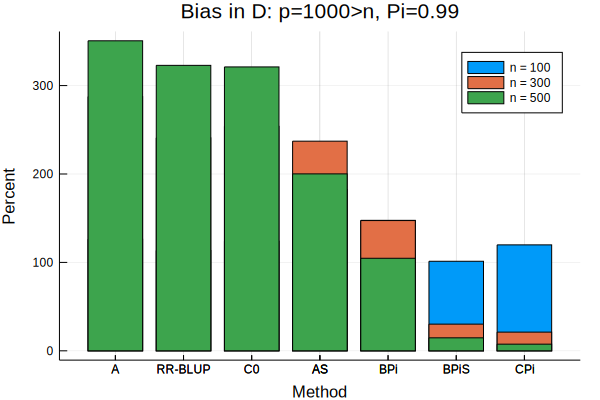

In [138]:
a = [23.08
     104.01
     69.27
     47.24 
     26.47 
     24.82 
     97.19
     97.60]
n500p1000 = (a[2:end] .- a[1])./a[1]*100
c  = [n100p1000 n300p1000 n500p1000]
sp = sortperm(c[:,3],rev=true)
x = m[sp]
y = c[sp,:]
bar(x,y,
    title = "Bias in D: p=1000>n, Pi=0.99",
    xlabel = "Method",
    ylabel = "Percent",
    label = ["n = 100" "n = 300" "n = 500"])

In [139]:
savefig("p1000bar.png")

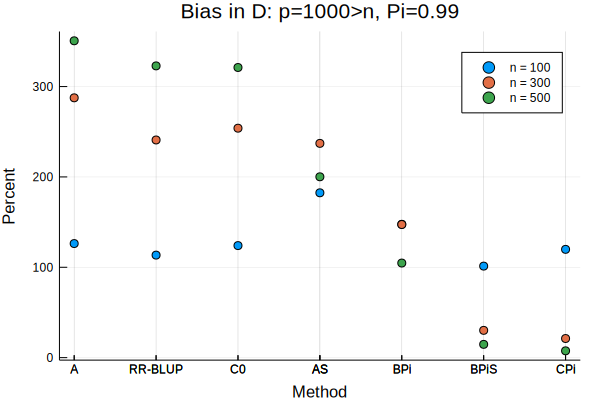

In [140]:
scatter(x,y,
    title = "Bias in D: p=1000>n, Pi=0.99",
    xlabel = "Method",
    ylabel = "Percent",
    label = ["n = 100" "n = 300" "n = 500"])

In [141]:
savefig("p1000scatter.png")

In [ ]:
using StatPlots

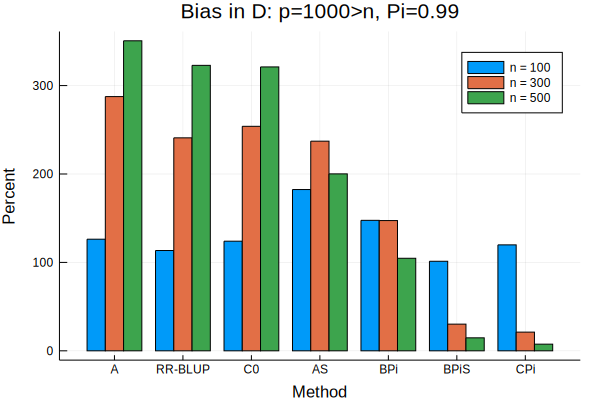

In [163]:
sp = sortperm(c[:,3],rev=true)
x = m[sp]
y = c[sp,:]
groupedbar(x,y,
    title = "Bias in D: p=1000>n, Pi=0.99",
    xlabel = "Method",
    ylabel = "Percent",
    label = ["n = 100" "n = 300" "n = 500"])

In [164]:
c

7×3 Array{Float64,2}:
 126.25   287.542   350.65   
 182.417  237.124   200.13   
 147.583  147.324   104.679  
 101.292   30.1839   14.688  
 119.833   21.1538    7.53899
 124.0    253.93    321.101  
 113.458  240.886   322.877  

In [45]:
biasMat = [row.estimates[i].result1 - row.trueVal for row in resSim, i =1:7]
res1 = [analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  80.9258   0.162356
 "BayesA Scale unknown"  46.1856   0.39531 
 "BayesB Scale known  "  24.1601   0.316837
 "BayesB Scale unknown"   3.39312  0.114708
 "BayesCPi            "   1.73984  0.115719
 "BayesC0             "  74.1093   1.10408 
 "RRBLUP              "  74.5203   0.505884

In [50]:
res1[:,2]/23.08*100

7-element Array{Float64,1}:
 350.6316902248511  
 200.11113413419886 
 104.67985736609097 
  14.701558703892362
   7.538303246192977
 321.0976371576201  
 322.8780505119123  

In [44]:
biasMat = [row.estimates[i].result2 - row.trueVal for row in resSim, i =1:7]
[analyses vec(mean(biasMat,dims=1)) vec(std(biasMat,dims=1))./N]

7×3 Array{Any,2}:
 "BayesA Scale known  "  180.219    0.066315
 "BayesA Scale unknown"  126.621    0.598748
 "BayesB Scale known  "   42.0677   0.488556
 "BayesB Scale unknown"    4.77057  0.179944
 "BayesCPi            "    2.22031  0.121567
 "BayesC0             "  198.353    1.80646 
 "RRBLUP              "  200.598    0.1587  

In [128]:
d = Normal(0,1)
x = -5:0.01:5
y = pdf.(d,x)
plot(x,y)